<a href="https://www.kaggle.com/code/luisfernandobuchelly/proyecto-final-giga-science-eegmi-gcpds?scriptVersionId=226037251" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Proyecto Final Señales y Sistemas 2024 -2

## **Objetivo**: Implementar técnicas de representación en tiempo y frecuencia para el reconocimiento de señales de electroencefalografía (EEG) en tareas de imaginación motora (Motor Imagery)

![sensorimotora](https://nepsa.es/wp-content/uploads/2021/10/Lengua-Mandibula-Labios-Cara-Ojo-Frente-Cuello-Pulgar-Dedos-Mano-Muneca-Codo-Brazo-Hombro-Maletero-Cadera-3.png)

![eegMI](https://figures.semanticscholar.org/288a54f091264377eccc99a19079c9387d66a78f/3-Figure2-1.png)

EEG signals can be noisy from a number of sources, including physiological artifacts and electromagnetic interference. They can also vary from person to person, which makes it harder to extract features and understand the signals. Additionally, this variability, influenced by genetic and cognitive factors, presents challenges for developing subject-independent solutions. 

**Base de datos**: GiGaScience Database [https://gigadb.org/dataset/100295](https://gigadb.org/dataset/100295)

Ver Sección 3.1 en [Multimodal Explainability Using Class Activation Maps and Canonical Correlation for MI-EEG Deep Learning Classification](https://www.mdpi.com/2076-3417/14/23/11208)


## Instalamos las librerias necesarias

## Ejercicio 1
Consultar para qué sirven las siguientes librerías

In [1]:
#!pip install tensorflow==2.15.0
!pip install mne==1.6.0
!pip install braindecode===0.7
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.databases

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 53.0 MB/s eta 0:00:00
  Attempting uninstall: mne
    Found existing installation: mne 1.9.0
    Uninstalling mne-1.9.0:
      Successfully uninstalled mne-1.9.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.4/184.4 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.9/228.9 kB 10.7 MB/s eta 0:00:00
  Cloning https://github.com/UN-GCPDS/python-gcpds.databases to /tmp/pip-req-build-o77iblwt
  Running command git clone --filter=blob:none --quiet https://github.com/UN-GCPDS/python-gcpds.databases /tmp/pip-req-build-o77iblwt
  Resolved https://github.com/UN-GCPDS/python-gcpds.databases to commit d174df9958b6638156dcfe03996a6307e631a6a2
  Preparing metadata (setup.py) ... done
  Created wheel for gcpds-databases: filename=gcpds_databases-0.2-py3-none-any.whl size=32972807 sha256=8f36091af0cff9bb30c43b3b10b58dccfc38254a2c9702f7854bfa37e78b1f40
  Stored in directory: /tmp/pip-ephem-wheel-cache-jxpu72hg/wheels/8e/66/a

Las librerías que mencionas son herramientas muy útiles para trabajar con señales cerebrales, especialmente en el campo de la electroencefalografía (EEG) y las interfaces cerebro-computadora (BCI). 

**tensorflow==2.15.0:** TensorFlow es una librería muy popular para trabajar con aprendizaje automático e inteligencia artificial. En este contexto, se usa para crear y entrenar modelos de redes neuronales que pueden analizar y clasificar patrones en los datos de EEG. La versión 2.15.0 es específica para asegurar que todo funcione sin problemas con las otras herramientas que se están utilizando.

**mne==1.6.0:** MNE es una librería especializada en el procesamiento de datos neurofisiológicos, como los que se obtienen con EEG. Con MNE, puedes cargar los datos, filtrarlos, eliminar artefactos (como ruido o movimientos oculares), extraer características importantes y visualizar las señales cerebrales. Es una herramienta muy completa para investigación y aplicaciones prácticas.

**braindecode===0.7:** Braindecode está diseñada específicamente para aplicar técnicas de aprendizaje profundo a señales cerebrales, como las de EEG. Incluye modelos de redes neuronales, como las redes convolucionales, que están optimizadas para trabajar con este tipo de datos. Es especialmente útil para tareas como clasificar la imaginación motora o detectar patrones específicos en la actividad cerebral.

**python-gcpds.databases:** Esta librería permite acceder a bases de datos de señales cerebrales, como EEG, que son útiles para entrenar y probar modelos en tareas de BCI. Estas bases de datos suelen contener registros de EEG asociados a tareas específicas, como la imaginación motora, lo que facilita el desarrollo y la validación de algoritmos.

## Importamos algunas librerias necesarias

In [2]:
from scipy.signal import resample
from scipy.signal import freqz, filtfilt, resample
from scipy.signal import butter as bw
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
#import tensorflow as tf
from gcpds.databases import GIGA_MI_ME
from sklearn.base import BaseEstimator, TransformerMixin

## Funciones necesarias para el preprocesamiento leve de los datos

In [3]:
def load_GIGA(db,
              sbj,
              eeg_ch_names,
              new_fs,
              fs,
              f_bank=None,
              vwt=None,           
              run=None):

    index_eeg_chs = db.format_channels_selectors(channels = eeg_ch_names) - 1

    #tf_repr = TimeFrequencyRpr(sfreq = fs, f_bank = f_bank, vwt = vwt)

    db.load_subject(sbj)
    if run == None:
        X, y = db.get_data(classes = ['left hand mi', 'right hand mi']) #Load MI classes, all channels {EEG}, reject bad trials, uV
    else:
        X, y = db.get_run(run, classes = ['left hand mi', 'right hand mi']) #Load MI classes, all channels {EEG}, reject bad trials, uV
    X = X[:, index_eeg_chs, :] #spatial rearrangement
    #X = np.squeeze(tf_repr.transform(X))
    #Resampling
    if new_fs == fs:
        pass#print('No resampling, since new sampling rate same.')
    else:
        print("Resampling from {:f} to {:f} Hz.".format(fs, new_fs))
        X = resample(X, int((X.shape[-1]/fs)*new_fs), axis = -1)

    return X, y

def butterworth_digital_filter(X, N, Wn, btype, fs, axis=-1, padtype=None, padlen=0, method='pad', irlen=None):
  """
  Apply digital butterworth filter
  INPUT
  ------
  1. X: (D array)
    array with signals.
  2. N: (int+)
    The order of the filter.
  3. Wn: (float+ or 1D array)
    The critical frequency or frequencies. For lowpass and highpass filters, Wn is a scalar; for bandpass and bandstop filters, Wn is a length-2 vector.
    For a Butterworth filter, this is the point at which the gain drops to 1/sqrt(2) that of the passband (the “-3 dB point”).
    If fs is not specified, Wn units are normalized from 0 to 1, where 1 is the Nyquist frequency (Wn is thus in half cycles / sample and defined as 2*critical frequencies / fs). If fs is specified, Wn is in the same units as fs.
  4. btype: (str) {‘lowpass’, ‘highpass’, ‘bandpass’, ‘bandstop’}
    The type of filter
  5. fs: (float+)
    The sampling frequency of the digital system.
  6. axis: (int), Default=1.
    The axis of x to which the filter is applied.
  7. padtype: (str) or None, {'odd', 'even', 'constant'}
    This determines the type of extension to use for the padded signal to which the filter is applied. If padtype is None, no padding is used. The default is ‘odd’.
  8. padlen: (int+) or None, Default=0
    The number of elements by which to extend x at both ends of axis before applying the filter. This value must be less than x.shape[axis] - 1. padlen=0 implies no padding.
  9. method: (str), {'pad', 'gust'}
    Determines the method for handling the edges of the signal, either “pad” or “gust”. When method is “pad”, the signal is padded; the type of padding is determined by padtype
    and padlen, and irlen is ignored. When method is “gust”, Gustafsson’s method is used, and padtype and padlen are ignored.
  10. irlen: (int) or None, Default=nONE
    When method is “gust”, irlen specifies the length of the impulse response of the filter. If irlen is None, no part of the impulse response is ignored.
    For a long signal, specifying irlen can significantly improve the performance of the filter.
  OUTPUT
  ------
  X_fil: (D array)
    array with filtered signals.
  """
  b, a = bw(N, Wn, btype, analog=False, output='ba', fs=fs)
  return filtfilt(b, a, X, axis=axis, padtype=padtype, padlen=padlen, method=method, irlen=irlen)

class TimeFrequencyRpr(BaseEstimator, TransformerMixin):
  """
  Time frequency representation of EEG signals.

  Parameters
  ----------
    1. sfreq:  (float) Sampling frequency in Hz.
    2. f_bank: (2D array) Filter banks Frequencies. Default=None
    3. vwt:    (2D array) Interest time windows. Default=None
  Methods
  -------
    1. fit(X, y=None)
    2. transform(X, y=None)
  """
  def __init__(self, sfreq, f_bank=None, vwt=None):
    self.sfreq = sfreq
    self.f_bank = f_bank
    self.vwt = vwt
# ------------------------------------------------------------------------------

  def _validation_param(self):
    """
    Validate Time-Frequency characterization parameters.
    INPUT
    -----
      1. self
    ------
      2. None
    """
    if self.sfreq <= 0:
      raise ValueError('Non negative sampling frequency is accepted')


    if self.f_bank is None:
      self.flag_f_bank = False
    elif self.f_bank.ndim != 2:
      raise ValueError('Band frequencies have to be a 2D array')
    else:
      self.flag_f_bank = True

    if self.vwt is None:
      self.flag_vwt = False
    elif self.vwt.ndim != 2:
      raise ValueError('Time windows have to be a 2D array')
    else:
      self.flag_vwt = True

# ------------------------------------------------------------------------------
  def _filter_bank(self, X):
    """
    Filter bank Characterization.
    INPUT
    -----
      1. X: (3D array) set of EEG signals, shape (trials, channels, time_samples)
    OUTPUT
    ------
      1. X_f: (4D array) set of filtered EEG signals, shape (trials, channels, time_samples, frequency_bands)
    """
    X_f = np.zeros((X.shape[0], X.shape[1], X.shape[2], self.f_bank.shape[0])) #epochs, Ch, Time, bands
    for f in np.arange(self.f_bank.shape[0]):
      X_f[:,:,:,f] = butterworth_digital_filter(X, N=4, Wn=self.f_bank[f], btype='bandpass', fs=self.sfreq)
    return X_f

# ------------------------------------------------------------------------------
  def _sliding_windows(self, X):
    """
    Sliding Windows Characterization.
    INPUT
    -----
      1. X: (3D array) set of EEG signals, shape (trials, channels, time_samples)
    OUTPUT
    ------
      1. X_w: (4D array) shape (trials, channels, window_time_samples, number_of_windows)
    """
    window_lenght = int(self.sfreq*self.vwt[0,1] - self.sfreq*self.vwt[0,0])
    X_w = np.zeros((X.shape[0], X.shape[1], window_lenght, self.vwt.shape[0]))
    for w in np.arange(self.vwt.shape[0]):
        X_w[:,:,:,w] = X[:,:,int(self.sfreq*self.vwt[w,0]):int(self.sfreq*self.vwt[w,1])]
    return X_w

# ------------------------------------------------------------------------------
  def fit(self, X, y=None):
    """
    fit.
    INPUT
    -----
      1. X: (3D array) set of EEG signals, shape (trials, channels, time_samples)
      2. y: (1D array) target labels. Default=None
    OUTPUT
    ------
      1. None
    """
    pass

# ------------------------------------------------------------------------------
  def transform(self, X, y=None):
    """
    Time frequency representation of EEG signals.
    INPUT
    -----
      1. X: (3D array) set of EEG signals, shape (trials, channels, times)
    OUTPUT
    ------
      1. X_wf: (5D array) Time-frequency representation of EEG signals, shape (trials, channels, window_time_samples, number_of_windows, frequency_bands)
    """
    self._validation_param()     #Validate sfreq, f_freq, vwt

    #Avoid edge effects of digital filter, 1st:fbk, 2th:vwt
    if self.flag_f_bank:
        X_f = self._filter_bank(X)
    else:
        X_f = X[:,:,:,np.newaxis]

    if self.flag_vwt:
      X_wf = []
      for f in range(X_f.shape[3]):
        X_wf.append(self._sliding_windows(X_f[:,:,:,f]))
      X_wf = np.stack(X_wf, axis=-1)
    else:
      X_wf = X_f[:,:,:,np.newaxis,:]

    return X_wf

#plot eeg   
def plot_eeg(X,tv,ax,channels,esp=2,title=None):
    # X in CH x Samples
    n_canales = X.shape[0]

    for ch in range(n_canales): # canales
            xx = X[ch]
            xx = xx - np.mean(xx)
            xx = xx/np.max(abs(xx))
            ax.plot(tv, xx +(ch * esp), label=channels[ch])  # Desplazamos cada canal para visualización
    ax.set_yticks(range(0, esp * n_canales, esp), channels)  # Etiquetas en el eje Y
    ax.set_xlabel("Tiempo [s]")
    ax.set_ylabel("Canales EEG [$\mu$V]")
    ax.set_title(title)
    ax.grid(True)
    ax.set_xlim([min(tv)-0.01,max(tv)+0.01])
    ax.set_ylim([-esp,n_canales*esp+0.01])





      

## Establecemos el protocolo de pruebas y la configuración del montaje EEG

Describir el protocolo de captura de datos y el montaje utilizado


![mi](https://www.mdpi.com/diagnostics/diagnostics-13-01122/article_deploy/html/images/diagnostics-13-01122-g001.png)
![montaje](https://www.mdpi.com/applsci/applsci-14-11208/article_deploy/html/images/applsci-14-11208-g001.png)

In [4]:
channels = ['Fp1','Fpz','Fp2',
            'AF7','AF3','AFz','AF4','AF8',
            'F7','F5','F3','F1','Fz','F2','F4','F6','F8',
            'FT7','FC5','FC3','FC1','FCz','FC2','FC4','FC6','FT8',
            'T7','C5','C3','C1','Cz','C2','C4','C6','T8',
            'TP7','CP5','CP3','CP1','CPz','CP2','CP4','CP6','TP8',
            'P9','P7','P5','P3','P1','Pz','P2','P4','P6','P8','P10',
            'PO7','PO3','POz','PO4','PO8',
            'O1','Oz','O2',
            'Iz']

areas = {
    'Frontal': ['Fpz', 'AFz', 'Fz', 'FCz'],
    'Frontal Right': ['Fp2','AF4','AF8','F2','F4','F6','F8',],
    'Central Right': ['FC2','FC4','FC6','FT8','C2','C4','C6','T8','CP2','CP4','CP6','TP8',],
    'Posterior Right': ['P2','P4','P6','P8','P10','PO4','PO8','O2',],
    #'Central': ['Cz'],
    'Posterior': ['CPz','Pz', 'Cz','POz','Oz','Iz',],
    'Posterior Left': ['P1','P3','P5','P7','P9','PO3','PO7','O1',],
    'Central Left': ['FC1','FC3','FC5','FT7','C1','C3','C5','T7','CP1','CP3','CP5','TP7',],
    'Frontal Left': ['Fp1','AF3','AF7','F1','F3','F5','F7',],
}

arcs = [
    #'hemispheres',
    'areas',
    'channels',
]

## Definimos la ruta y los argumentos para la carga de los datos de EEG

In [5]:
db = GIGA_MI_ME('/kaggle/input/giga-science-gcpds/GIGA_MI_ME')
#ti = 0
#tf = 7
new_fs = 256.
load_args = dict(db = db,
                 eeg_ch_names = channels,
                 fs = db.metadata['sampling_rate'],
                 #f_bank = np.asarray([[4., 40.]]),
                 #vwt = np.asarray([[ti, tf]]), #2.5 - 5 MI
                 new_fs = new_fs)

## Cargamos los datos según el sujeto que se quiera

Si se quiere cargar los datos de todos los sujetos, aplicar un ciclo que itere la lista de sujetos y de esta forma se cargara uno por uno dependiendo lo que se desee realizar.

Por ejemplo:

for i in sbj:
    X, y = load_GIGA(sbj=sbj, **load_args)

In [6]:
sbj = 3
X, y = load_GIGA(sbj=sbj, **load_args)

Resampling from 512.000000 to 256.000000 Hz.


In [7]:
print(f'X con {X.shape[0]} intentos; {X.shape[1]} canales; {X.shape[2]} muestras No. de segundos {X.shape[2]/new_fs}')

X con 200 intentos; 64 canales; 1792 muestras No. de segundos 7.0


In [8]:
X.shape

(200, 64, 1792)

## Visualización de las señales de EEG en el tiempo

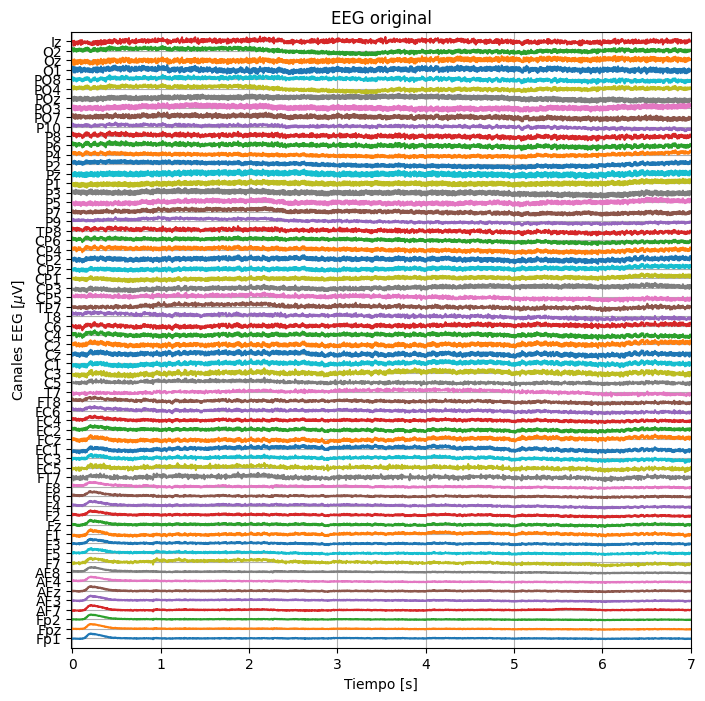

In [9]:
#graficar canales promedio
trial = 0
ti = 0 # ti
tf = 7 # tf
tv = np.arange(ti,tf,1/new_fs)

#Señal cruda
fig,ax = plt.subplots(1,1,figsize=(8,8),sharex = True)
# Graficar cada canal en un subplot banda respectiva

plot_eeg(X[trial],tv,ax=ax,channels=channels,title='EEG original')
plt.show()

# Ejercicio 2

Discuta la gráfica anterior

La imagen muestra la actividad EEG en bruto de un sujeto, capturada mediante 64 canales distribuidos según el sistema estándar 10-20, durante un periodo de 7 segundos. A continuación, se describen algunos aspectos relevantes que se pueden observar en esta gráfica:

**Organización de los canales:** Cada canal se representa de manera paralela, con un desplazamiento vertical para evitar que las señales se superpongan y facilitar su comparación visual. En el eje Y se encuentran las etiquetas de los canales, ordenados desde Fp1 (frontal) hasta Oz (occipital), lo que permite identificar fácilmente la región del cuero cabelludo asociada a cada trazo.

**Variabilidad en las amplitudes:** Se aprecian diferencias en las amplitudes entre los canales, lo cual es normal en un registro EEG, ya que cada área del cerebro puede presentar distinta potencia en las bandas de frecuencia. Aunque la señal está en microvoltios (μV), es probable que se haya reescalado para mejorar su visualización.

**Posibles artefactos:** En algunas trazas se observan fluctuaciones abruptas o picos aislados, que podrían deberse a parpadeos, movimientos musculares o ruido externo. Estos artefactos son comunes en las señales EEG crudas y suelen corregirse en etapas posteriores de filtrado o preprocesamiento.

**Oscilaciones en la señal:** En ciertos momentos, se distinguen ondulaciones que podrían corresponder a ritmos característicos, como el ritmo alfa (8-12 Hz) o beta (13-30 Hz). Sin embargo, en la señal cruda es difícil identificarlos con precisión sin un filtrado específico. En el contexto de una tarea de imaginación motora (como las propias del conjunto de datos GIGA_MI_ME), estas oscilaciones podrían estar relacionadas con la actividad cortical asociada al movimiento imaginado.

**Intervalo temporal (0-7 segundos):** Este intervalo de 7 segundos podría corresponder a una fase de reposo o a la fase de imaginación motora. En estudios de imaginación motora (MI), es común analizar una ventana de tiempo específica (por ejemplo, de 2 a 6 segundos) después de la instrucción, para extraer características asociadas a la actividad motora.

**Procesamiento y análisis posterior:** Antes de realizar un análisis más profundo (como la clasificación de movimientos imaginados hacia la izquierda o la derecha), es necesario aplicar técnicas de preprocesamiento. Esto incluye el filtrado (pasa banda, eliminación de ruido de línea, etc.), la corrección de artefactos y el re-referenciado de la señal (a un canal específico o al promedio de varios canales). Posteriormente, se extraen características relevantes, como las potencias en bandas de frecuencia o los patrones de ERD/ERS (Event-Related Desynchronization/Synchronization), o se transforman las señales utilizando algoritmos como CSP (Common Spatial Patterns), wavelets o redes neuronales.

Nota: Recuerde el concepto de ritmos cerebrales

![montaje](https://cdn.shopify.com/s/files/1/0348/7053/files/storage.googleapis.com-486681944373284_61cb9936-f6c2-493d-8402-3426d7f5a049_1024x1024.jpg?v=1689309340)



In [10]:
# filtramos trials completos en ritmos cerebrales utilizando filtros IIR


f_bank = np.array([[0.5,4.],[4., 8.],[8.,13.],[13.,32.],[32.,100.]])
vwt = np.asarray([[ti, tf]]) #2.5 - 5 MI 0 - 7 trial completo
tf_repr = TimeFrequencyRpr(sfreq = new_fs, f_bank = f_bank)

Xrc = np.squeeze(tf_repr.transform(X))

Xrc.shape

(200, 64, 1792, 5)

# Ejercicio 3

Expliqué cómo se calcularon cada una de las 5 dimensiones del arreglo Xrc

La clase TimeFrequencyRpr crea un arreglo de hasta 5 dimensiones con la siguiente forma:

(N_trials, N_canales, N_muestras_tiempo, N_ventanas, N_bandas_frecuencia)

Si alguna de estas dimensiones tiene un tamaño de 1 (por ejemplo, si solo hay una ventana de tiempo), al usar np.squeeze(Xrc), esa dimensión se elimina, y el arreglo final queda con 4 dimensiones. 

**Trials (N_trials):** Es el número de intentos o épocas que se cargan. Por ejemplo, si tienes 24 ensayos de imaginación motora, esta dimensión será 24.

**Canales (N_canales):** Corresponde al número de electrodos EEG que estás usando. En este caso, son 64 canales (siguiendo el sistema 10-20 extendido).

**Muestras en el Tiempo (N_muestras_tiempo):** Es la cantidad de puntos de muestreo en cada ensayo. Si defines una ventana de 7 segundos y usas una frecuencia de muestreo de 256 Hz, obtienes 7 × 256 = 1792 muestras por ensayo.

**Ventanas de Tiempo (N_ventanas):** Aquí defines las ventanas de tiempo que quieres analizar. Si solo usas una ventana de 0 a 7 segundos, esta dimensión será 1. Si divides el ensayo en varias ventanas (por ejemplo, de 2 a 4 s y de 4 a 6 s), esta dimensión aumentará.

**Bandas de Frecuencia (N_bandas_frecuencia):** Esta dimensión viene del banco de filtros que defines. Por ejemplo, si usas 5 bandas (delta, theta, alpha, beta y gamma), esta dimensión será 5.

El método transform de la clase hace dos cosas principales:

* Filtra la señal en cada banda de frecuencia, agregando una dimensión extra para las bandas.

* Segmenta la señal en ventanas de tiempo, agregando otra dimensión si hay más de una ventana.

Como en este caso solo hay una ventana, esa dimensión es 1, y al aplicar np.squeeze, se elimina, quedando un arreglo de 4 dimensiones:

(N_trials, N_canales, N_muestras_tiempo, N_bandas_frecuencia)

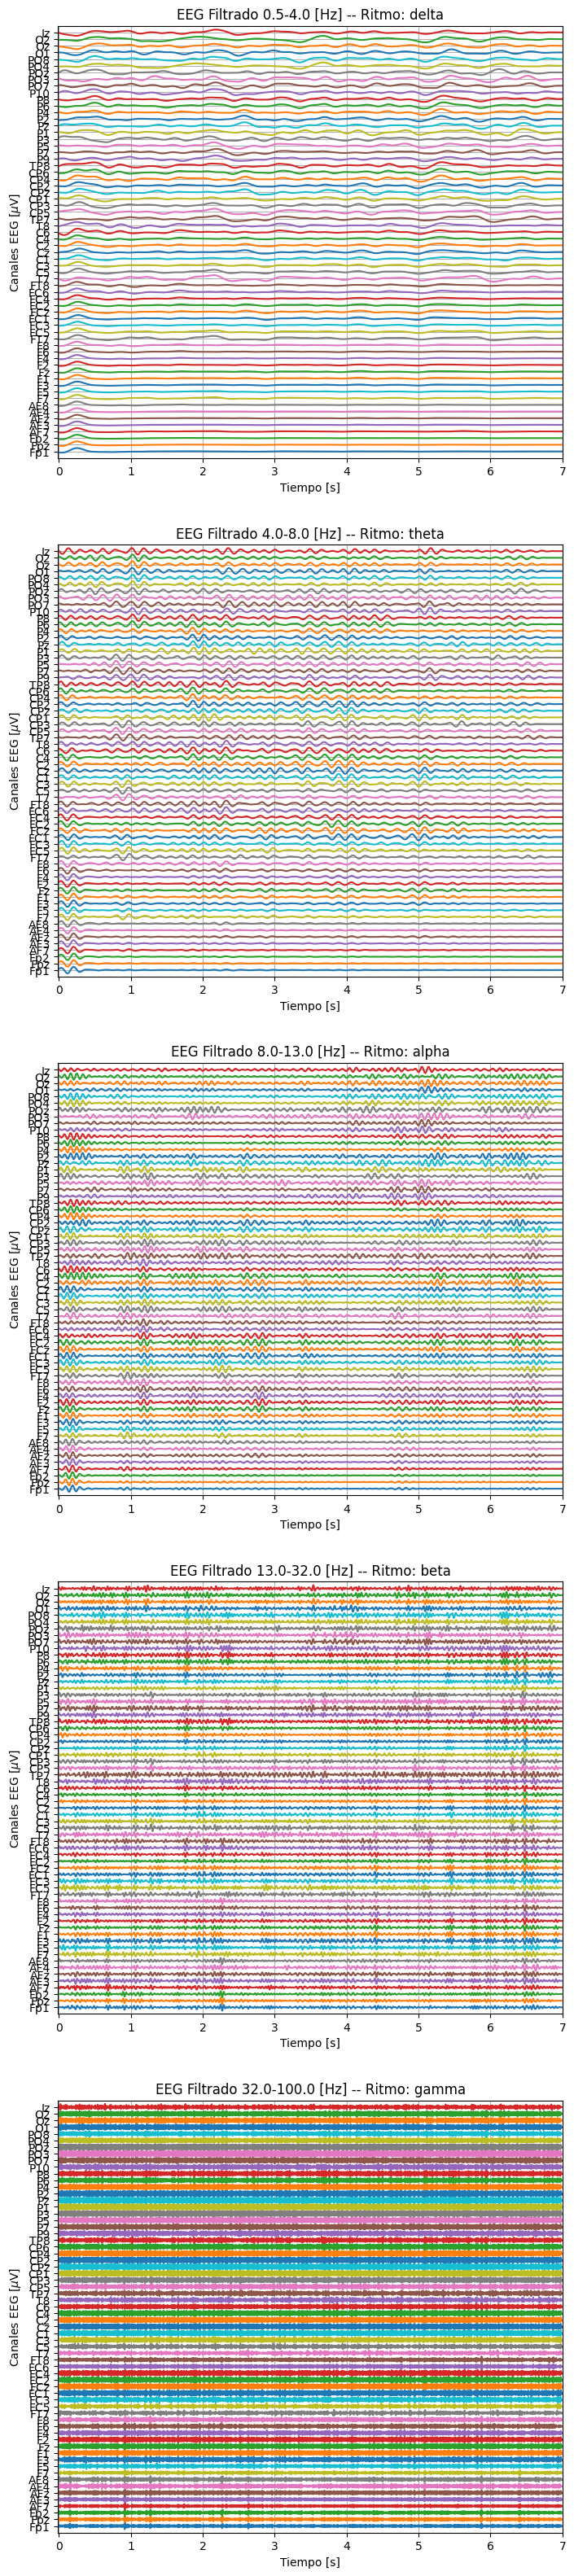

In [11]:
import matplotlib.pyplot as plt

ritmo = ['delta','theta','alpha','beta','gamma']
trial = 0
n_trials, n_canales, n_muestras, n_bands = Xrc.shape  # Simulación de datos

esp = 2 #espaciado canales
fig,ax = plt.subplots(5,1,figsize=(8,40))
# Graficar cada canal en un subplot banda respectiva
for b in range(f_bank.shape[0]): #bandas
    plot_eeg(Xrc[trial,:,:,b],tv,ax=ax[b],channels=channels,title=f'EEG Filtrado {f_bank[b,0]}-{f_bank[b,1]} [Hz] -- Ritmo: {ritmo[b]}')
plt.show()

## Visualización de las señales de EEG en la frecuencia

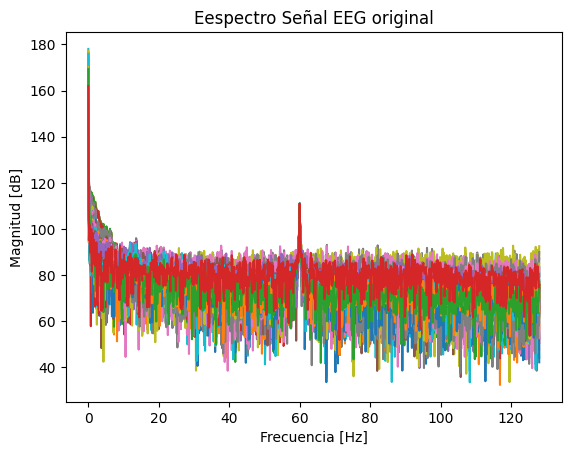

In [12]:
#señal orignal
Xwo = np.fft.rfft(X,axis=-1)
vfreq = np.fft.rfftfreq(X.shape[2],1/new_fs)

Xwo.shape
plt.plot(vfreq,20*np.log10(np.abs(Xwo[trial])).T)
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.title('Eespectro Señal EEG original')
plt.show()


## Ejercicio 4

Discuta la gráfica anterior

La imagen muestra el espectro de una señal EEG original, lo que nos permite ver cómo se distribuye la energía de la señal en diferentes frecuencias. En el eje vertical se representa la magnitud en decibelios (dB), indicando la intensidad de cada componente de frecuencia, mientras que en el eje horizontal se muestra la frecuencia en Hertz (Hz), abarcando desde 0 Hz hasta 120 Hz. Este rango cubre las bandas de frecuencia que habitualmente se analizan en estudios de EEG.

En el espectro, podemos identificar varias bandas de frecuencia que están asociadas con distintos estados de actividad cerebral. La banda delta (0.5–4 Hz) está relacionada con el sueño profundo, mientras que la banda theta (4–8 Hz) suele aparecer en estados de relajación o somnolencia. La actividad alpha (8–13 Hz) es común cuando la persona está relajada, especialmente con los ojos cerrados. Por otro lado, la banda beta (13–30 Hz) se asocia con la concentración y la actividad mental, y la gamma (30–100 Hz) está vinculada a procesos cognitivos más complejos.

Cuando se observan picos en alguna de estas bandas, esto sugiere que esa frecuencia en particular está predominando en la actividad cerebral en ese momento. Por ejemplo, un pico en la banda alpha podría indicar un estado de relajación durante la grabación de la señal EEG. Sin embargo, también es posible encontrar picos inesperados o componentes de alta frecuencia que no corresponden a la actividad cerebral habitual, lo cual podría deberse a la presencia de ruido o artefactos como movimientos musculares, parpadeos o interferencias externas.

Este tipo de representación es sumamente valiosa, ya que nos permite identificar patrones de actividad cerebral, diagnosticar posibles trastornos neurológicos y desarrollar interfaces cerebro-computadora (BCI). La comprensión del comportamiento de la señal EEG en función de sus componentes frecuenciales es clave para el análisis y la interpretación precisa de la actividad eléctrica del cerebro.



In [13]:
#espectro señales filtradas
Xwb = np.fft.rfft(Xrc,axis=2)

Xwb.shape

(200, 64, 897, 5)

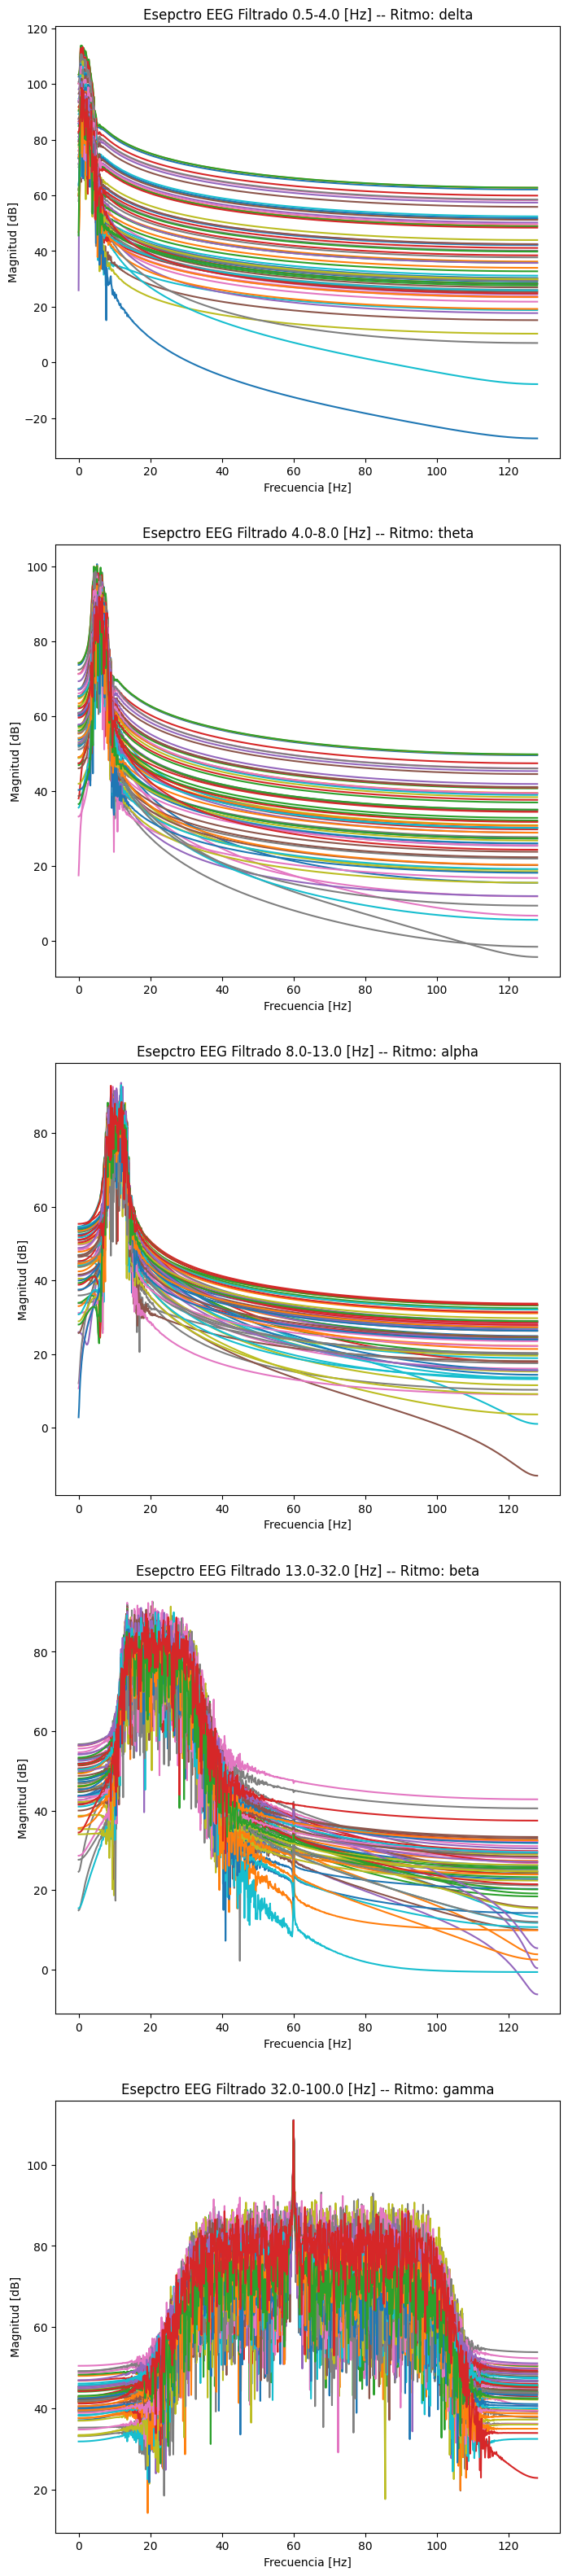

In [14]:
#espectro señales filtradas por bandas - ritmos cerebrales

fig,ax = plt.subplots(5,1,figsize=(8,40))
# Graficar cada canal en un subplot banda respectiva
for b in range(f_bank.shape[0]): #bandas
    ax[b].plot(vfreq,20*np.log10(np.abs(Xwb[trial,:,:,b])).T)
    ax[b].set_xlabel('Frecuencia [Hz]')
    ax[b].set_ylabel('Magnitud [dB]')
    ax[b].set_title(f'Esepctro EEG Filtrado {f_bank[b,0]}-{f_bank[b,1]} [Hz] -- Ritmo: {ritmo[b]}')
    
plt.show()

## Ejercicio 5

Discuta las gráficas

Estas gráficas muestran el espectro de frecuencia de señales EEG que han sido filtradas en distintas bandas, cada una asociada a un ritmo cerebral específico: delta, theta, alpha, beta y gamma. En cada gráfico se representa la magnitud en decibelios (dB) en función de la frecuencia en Hertz (Hz). Explicados acontinuacion.

1. Espectro EEG Filtrado 0.5–4.0 Hz – Ritmo: Delta

Descripción:
Esta gráfica nos muestra la magnitud en decibelios (dB) de la actividad EEG dentro del rango de 0.5 a 4 Hz, que corresponde al ritmo delta.

Análisis:
El ritmo delta se asocia con estados de sueño profundo o una relajación muy intensa. En la imagen se aprecia un pico bastante marcado en ese rango, lo que indica que hay una presencia fuerte de actividad delta. Además, la magnitud disminuye rápidamente fuera de ese intervalo, lo que confirma que el filtro ha logrado aislar eficazmente esta banda de frecuencia.

Interpretación:
Un pico tan prominente en la banda delta sugiere que el sujeto probablemente estaba en un estado de sueño profundo o, al menos, en un estado de relajación extrema en el momento de la grabación.

2. Espectro EEG Filtrado 4.0–8.0 Hz – Ritmo: Theta

Descripción:
Aquí se observa la magnitud de la actividad EEG en el rango de 4 a 8 Hz, correspondiente al ritmo theta.

Análisis:
El ritmo theta suele estar vinculado a estados de somnolencia, meditación o incluso al procesamiento emocional. En esta gráfica se nota un pico significativo en este rango, lo que indica una presencia notable de actividad theta. Fuera de este rango, la magnitud se reduce considerablemente, evidenciando que el filtro ha sido efectivo.

Interpretación:
La presencia de esta actividad theta sugiere que el sujeto pudo haber estado en un estado de relajación profunda, somnolencia o incluso en una especie de meditación durante la adquisición de los datos.

3. Espectro EEG Filtrado 8.0–13.0 Hz – Ritmo: Alpha

Descripción:
Esta gráfica representa la magnitud de la actividad EEG en el rango de 8 a 13 Hz, lo que corresponde al ritmo alpha.

Análisis:
El ritmo alpha se asocia generalmente con un estado de relajación tranquila y, a menudo, se observa cuando la persona tiene los ojos cerrados. La gráfica muestra un pico claro en este intervalo, indicando una fuerte presencia de actividad alpha. La caída de la magnitud fuera de este rango confirma que el filtro ha aislado correctamente esta banda.

Interpretación:
La prominencia de la actividad alpha nos indica que el sujeto probablemente estaba en un estado de relajación o con los ojos cerrados durante la grabación.

4. Espectro EEG Filtrado 13.0–32.0 Hz – Ritmo: Beta

Descripción:
Esta gráfica ilustra la magnitud de la actividad EEG en el rango de 13 a 32 Hz, correspondiente al ritmo beta.

Análisis:
El ritmo beta se relaciona con estados de alerta, concentración y actividad mental activa. En la gráfica se aprecia un pico significativo en este rango, lo que sugiere una activa presencia de actividad beta. La magnitud disminuye fuera de este intervalo, demostrando que el filtro ha hecho su trabajo.

Interpretación:
La presencia de actividad beta indica que el sujeto probablemente se encontraba en un estado de alerta o estaba realizando alguna tarea cognitiva en el momento de la adquisición de los datos.

5. Espectro EEG Filtrado 32.0–100.0 Hz – Ritmo: Gamma

Descripción:
Esta gráfica muestra la magnitud de la actividad EEG en el rango de 32 a 100 Hz, correspondiente al ritmo gamma.

Análisis:
El ritmo gamma está asociado con procesos cognitivos complejos, como la percepción, la atención y la memoria. En la gráfica, la magnitud es relativamente baja en comparación con las otras bandas, lo cual es habitual, ya que la actividad gamma suele ser de menor amplitud. Aun así, se observa actividad en este rango, lo que indica que el filtro ha capturado esta banda de frecuencia.

Interpretación:
La actividad gamma, aunque menos prominente, sugiere que el sujeto podría haber estado involucrado en procesos cognitivos complejos durante la grabación.

Conclusiones generales

Efectividad del filtrado:
En todas las gráficas se evidencia que el filtro ha funcionado correctamente: la magnitud es alta en el rango de interés y cae notablemente fuera de él.

Estados cerebrales:
Cada banda de frecuencia refleja diferentes estados del cerebro, desde la relajación profunda (alpha) hasta estados de alerta y actividad mental (beta y gamma).

Aplicaciones:
Este tipo de análisis es muy útil en diversas áreas, como la neurofeedback, el estudio del sueño o el diagnóstico de trastornos neurológicos, ya que nos permite identificar patrones y estados específicos en la actividad cerebral.

## Visualización de espectrogramas

Consultar Short Time Fourier Transform



(200, 64, 65, 29)


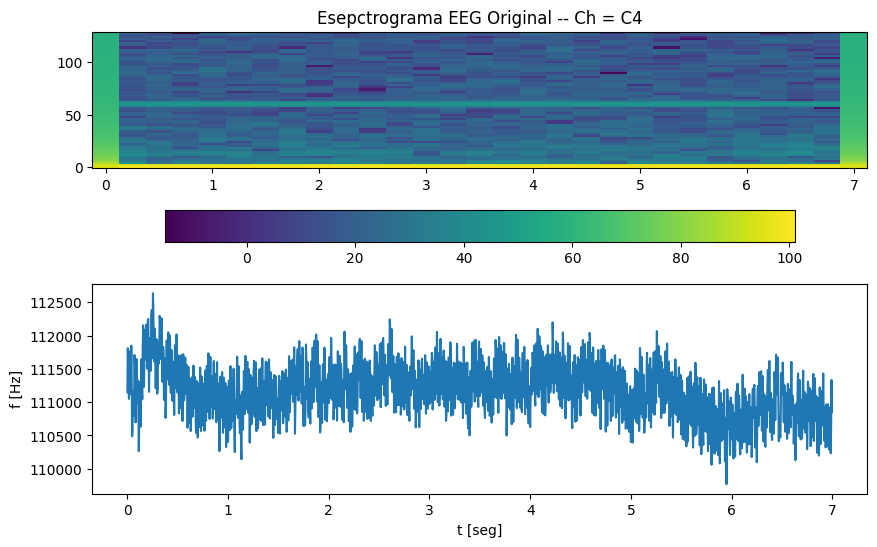

In [15]:
#estimar stft con ventanas de nperseg puntos sobre eje temporal en EEG original
from scipy.signal import stft #
nperseg = 0.5*new_fs#longitud ventas en muestras
vfs,t,Xstft = stft(X,fs=new_fs,nperseg=nperseg,axis=2)
Xstft = 20*np.log10(abs(Xstft))

#graficar stft para un trial y un canal
trail = 0
chi = channels.index('C4')

fig, ax = plt.subplots(2, 1,figsize=(10,6))

ax[1].plot(tv,X[trail,chi,:])
ax[1].set_ylabel("Amp. [$\mu$ V]")
im = ax[0].pcolormesh(t, vfs, Xstft[trail,chi])
fig.colorbar(im, ax=ax[0],orientation="horizontal",pad=0.2)
plt.gca()
plt.xlabel('t [seg]')
plt.ylabel('f [Hz]')
ax[0].set_title(f'Esepctrograma EEG Original -- Ch = {channels[chi]}')
print(Xstft.shape)

(200, 64, 65, 5, 29)


Text(0.5, 1.0, 'Esepctrograma EEG Filtrado 8.0-13.0 [Hz] -- Ritmo: alpha -- Ch = C4')

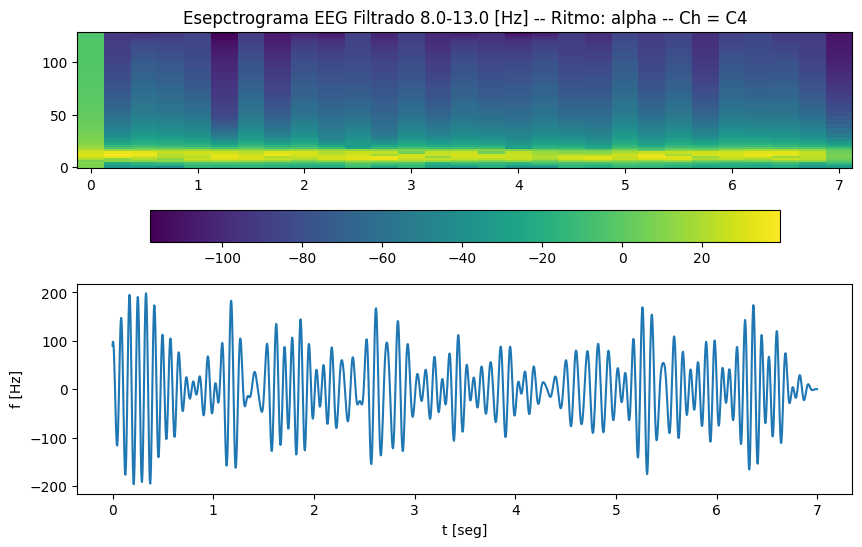

In [16]:
#estimar stft con ventanas de nperseg puntos sobre eje temporal en EEG original
b = 2
vfs,t,Xstftb = stft(Xrc,fs=new_fs,nperseg=nperseg,axis=2)
Xstftb = 20*np.log10(abs(Xstftb))

print(Xstftb.shape)


fig, ax = plt.subplots(2, 1,figsize=(10,6))
ax[1].plot(tv,Xrc[trail,chi,:,b])
ax[1].set_ylabel("Amp. [$\mu$ V]")
im = ax[0].pcolormesh(t, vfs, Xstftb[trail,chi,:,b,:])
fig.colorbar(im, ax=ax[0],orientation="horizontal",pad=0.2)
plt.gca()
plt.xlabel('t [seg]')
plt.ylabel('f [Hz]')
ax[0].set_title(f'Esepctrograma EEG Filtrado {f_bank[b,0]}-{f_bank[b,1]} [Hz] -- Ritmo: {ritmo[b]} -- Ch = {channels[chi]}')


# Ejercicio 6

Presente las gráficas de stft para distintos canales en los 5 ritmos cerebrales y discuta.

Procesando ritmo: delta (0.5-4.0 Hz)


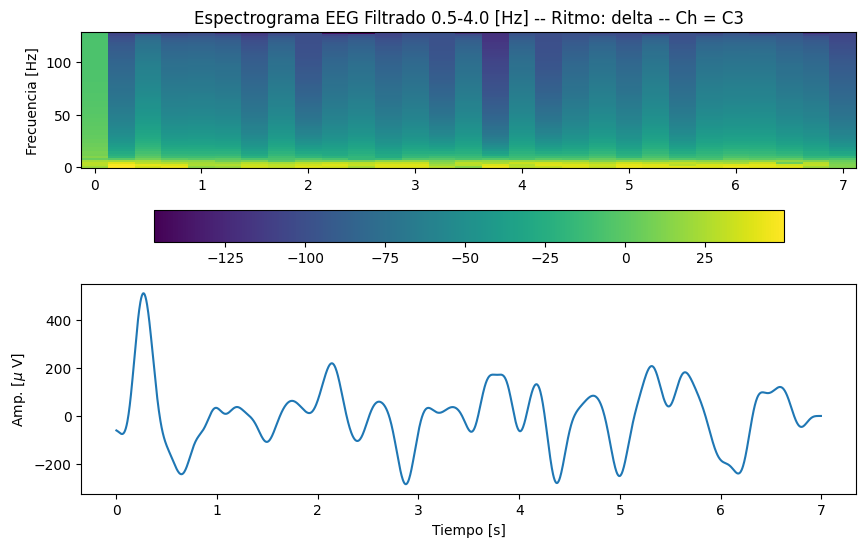

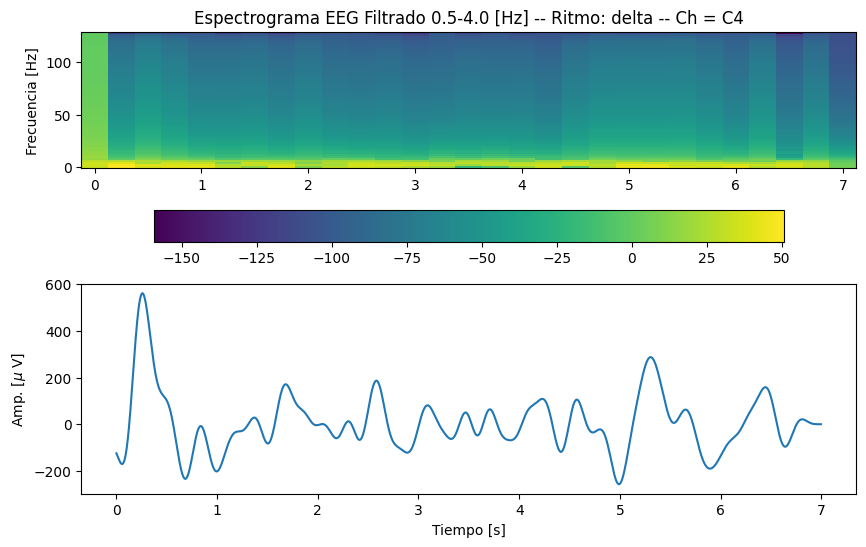

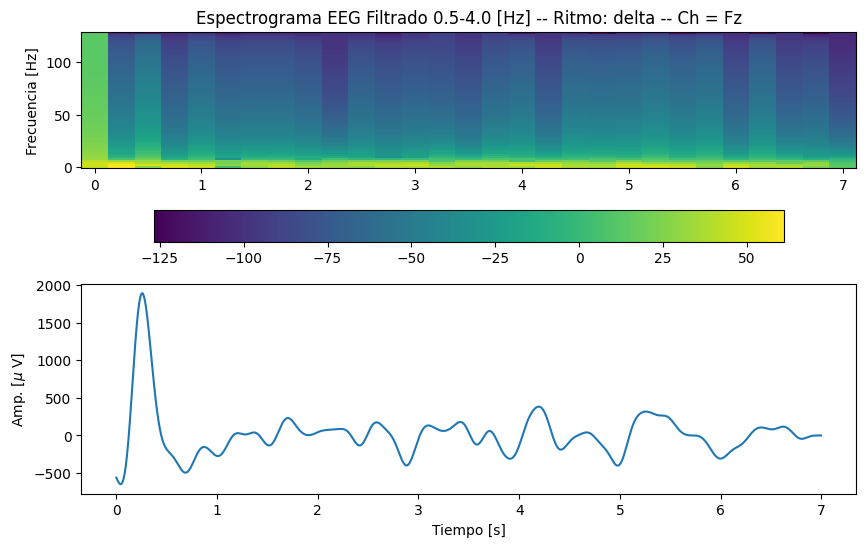

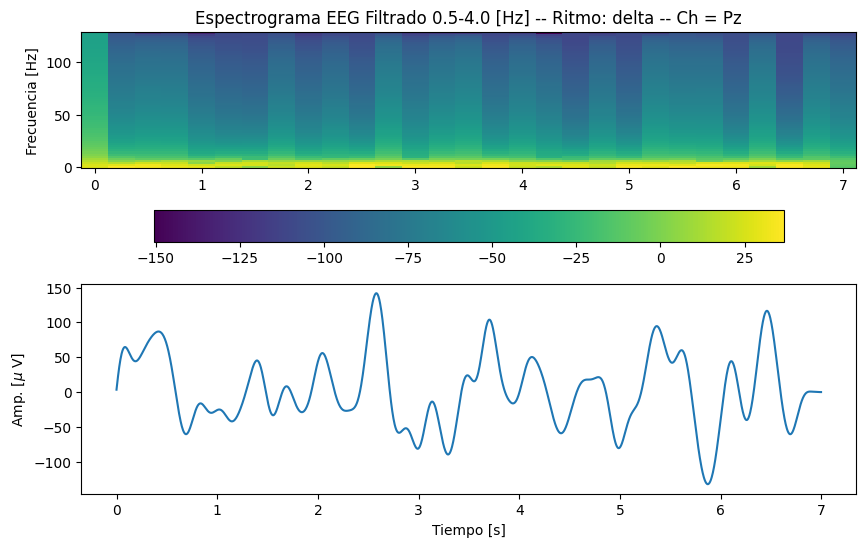

Procesando ritmo: theta (4.0-8.0 Hz)


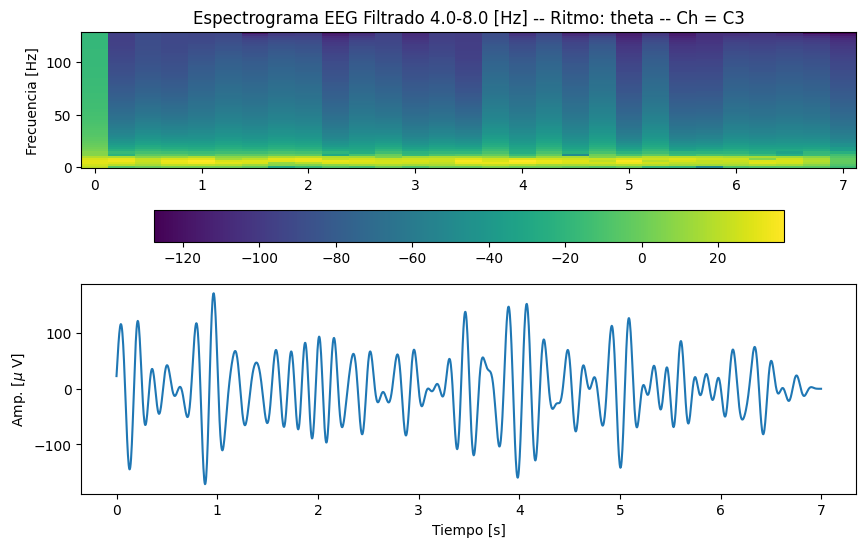

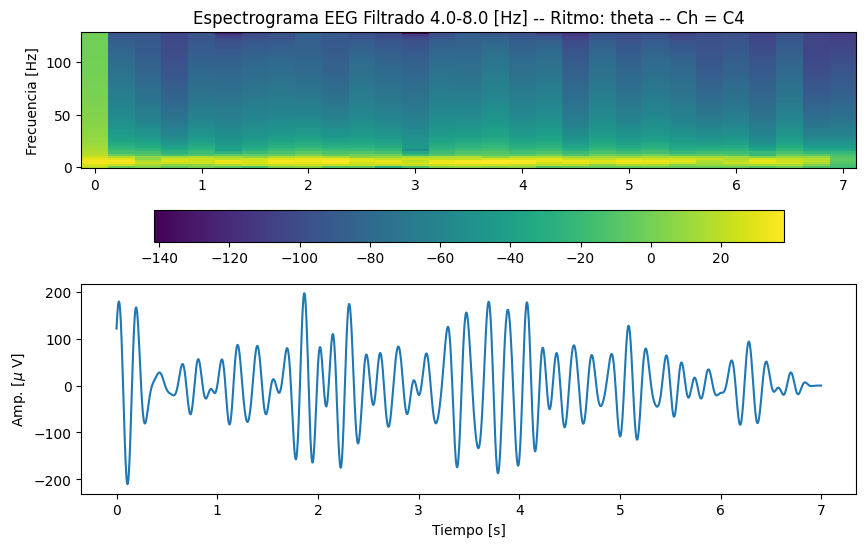

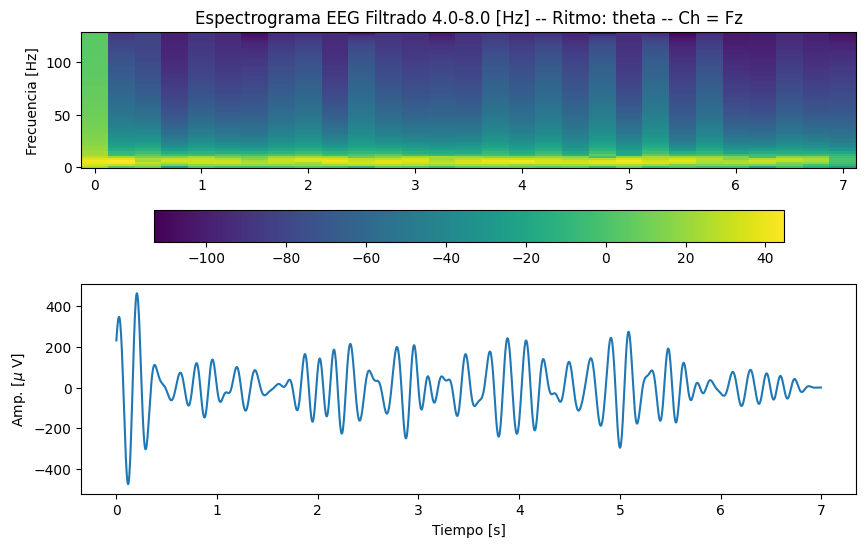

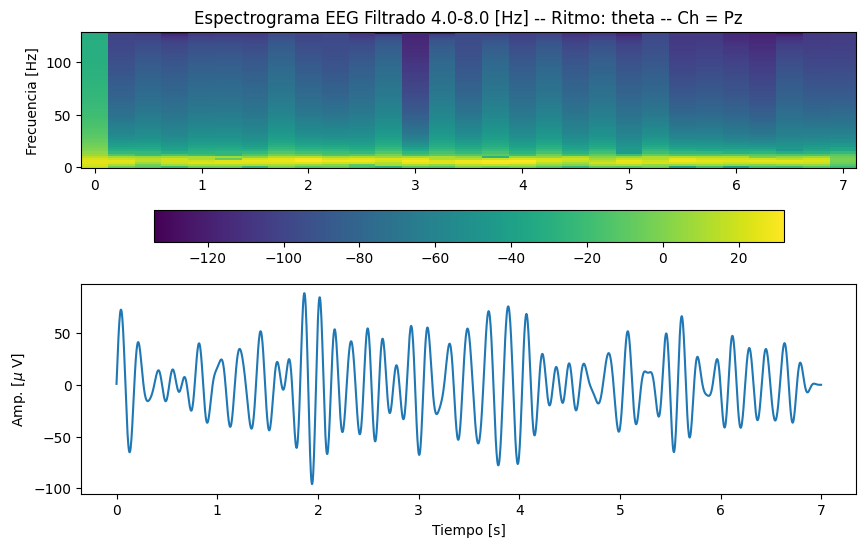

Procesando ritmo: alpha (8.0-13.0 Hz)


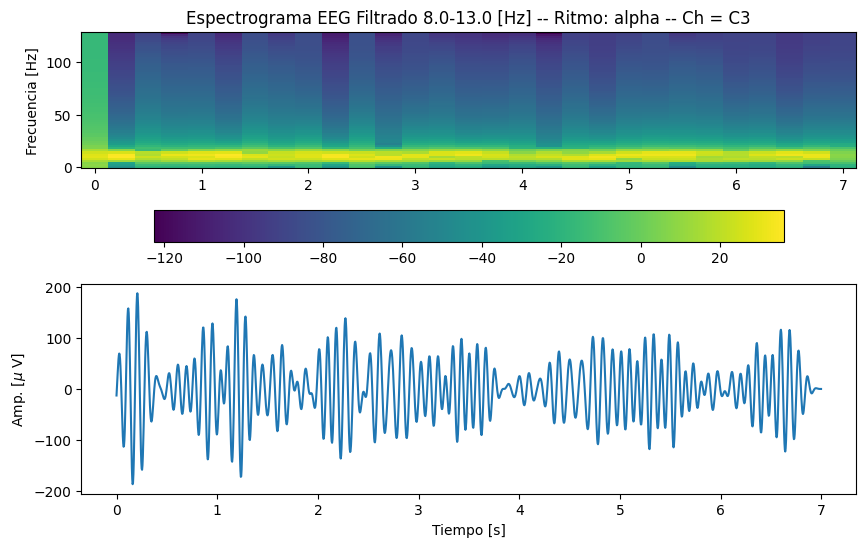

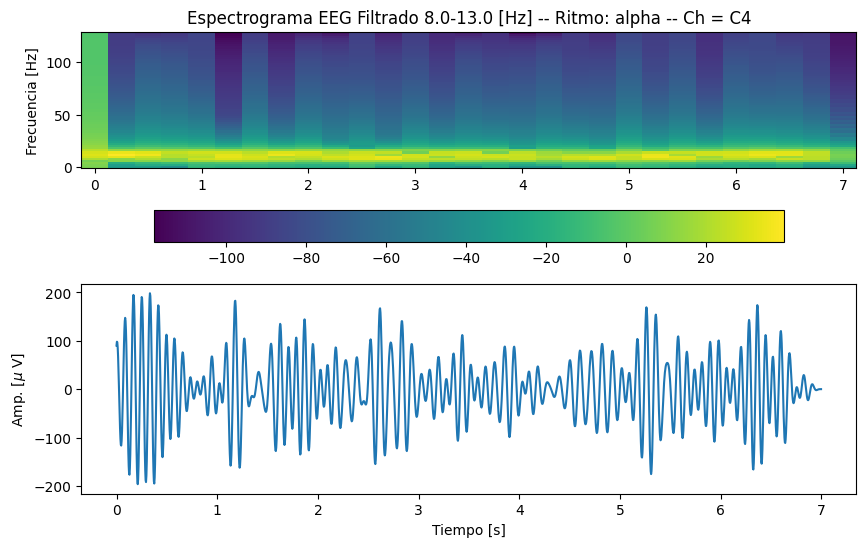

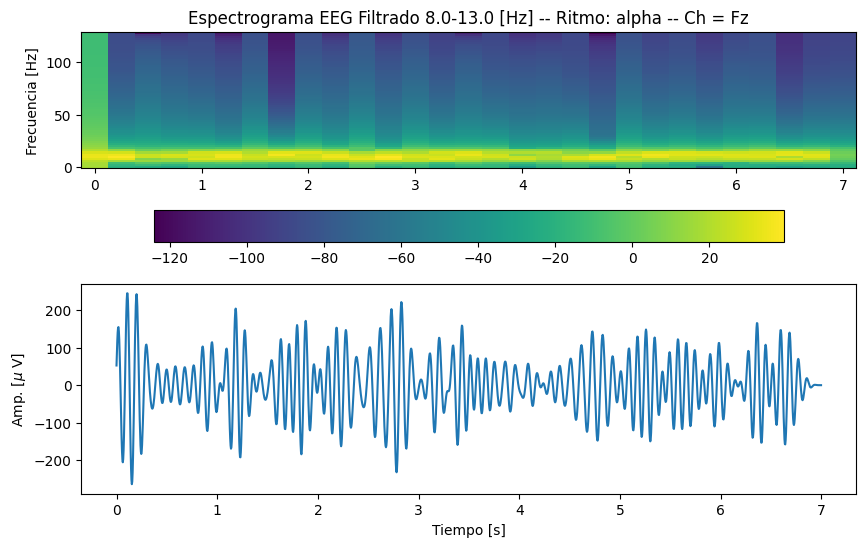

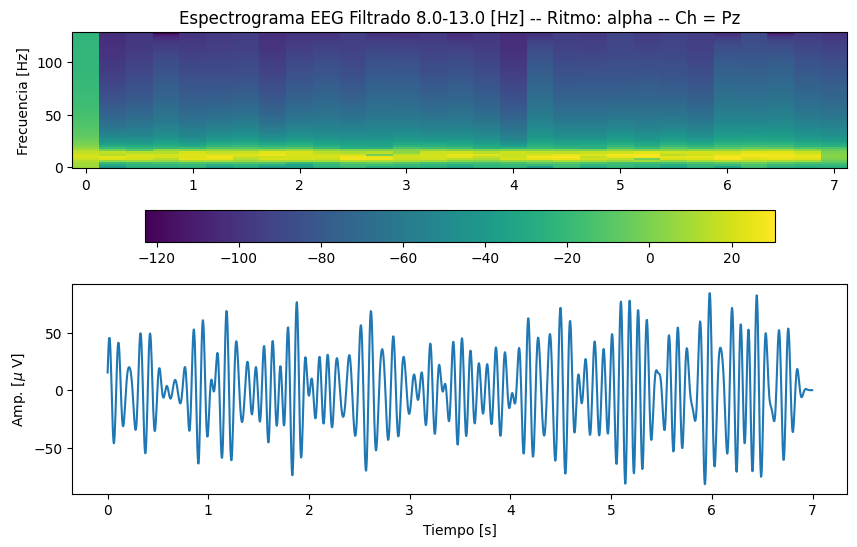

Procesando ritmo: beta (13.0-32.0 Hz)


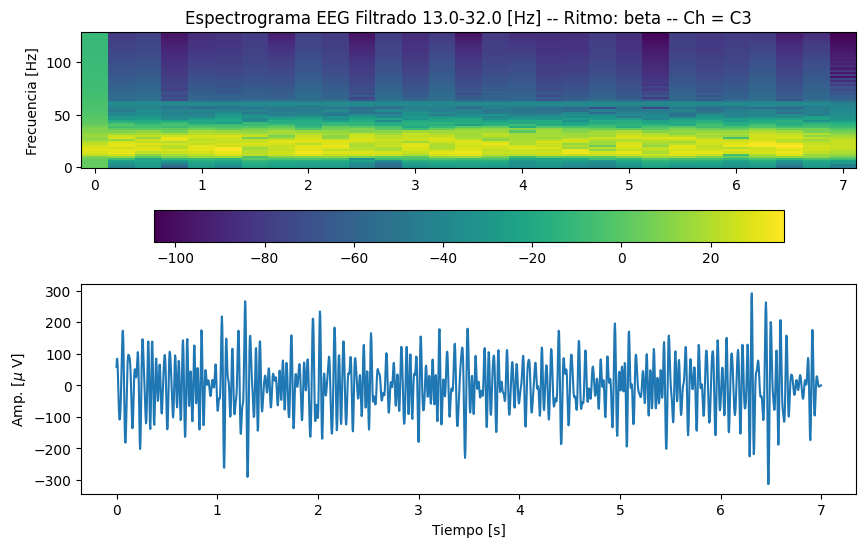

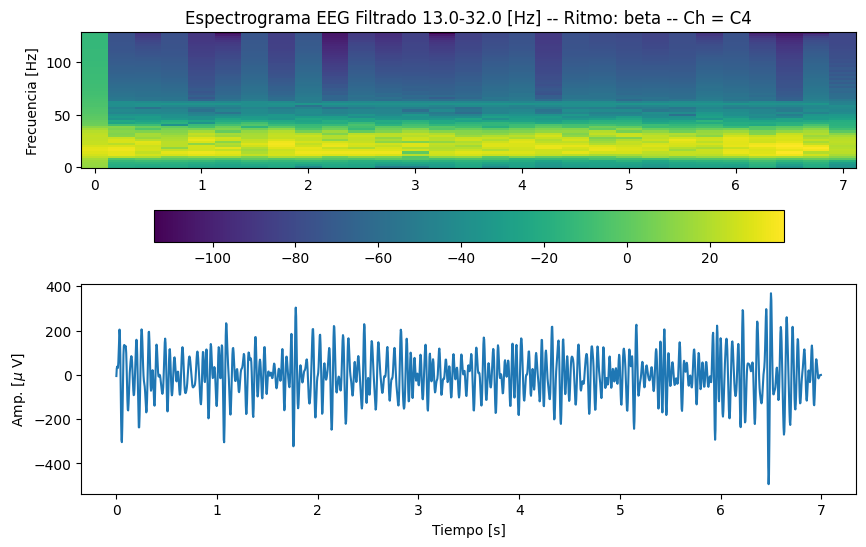

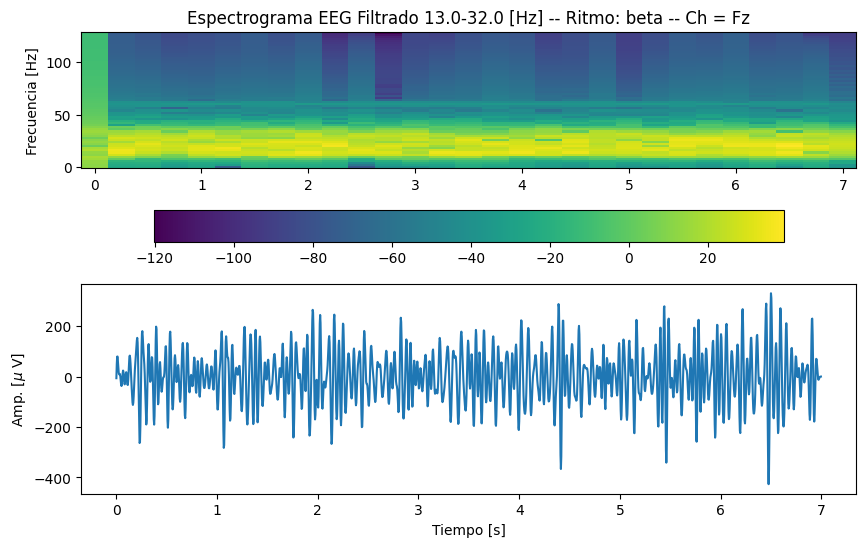

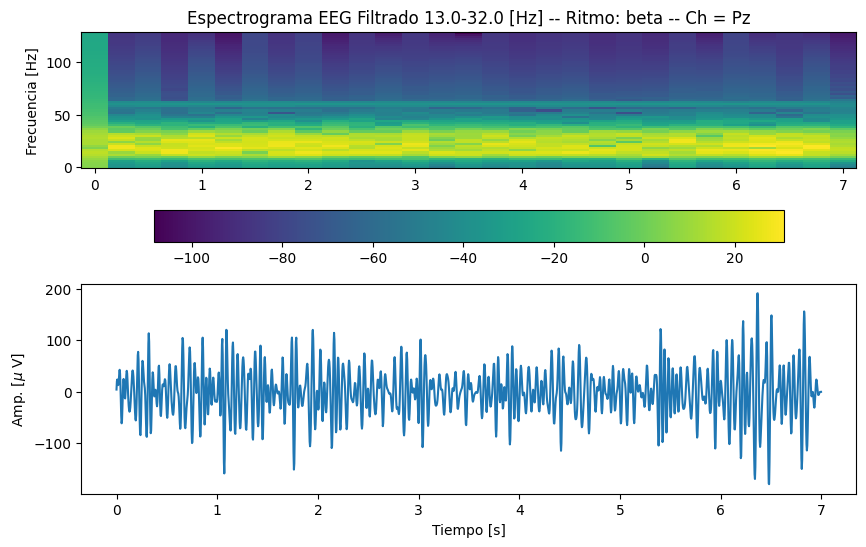

Procesando ritmo: gamma (32.0-100.0 Hz)


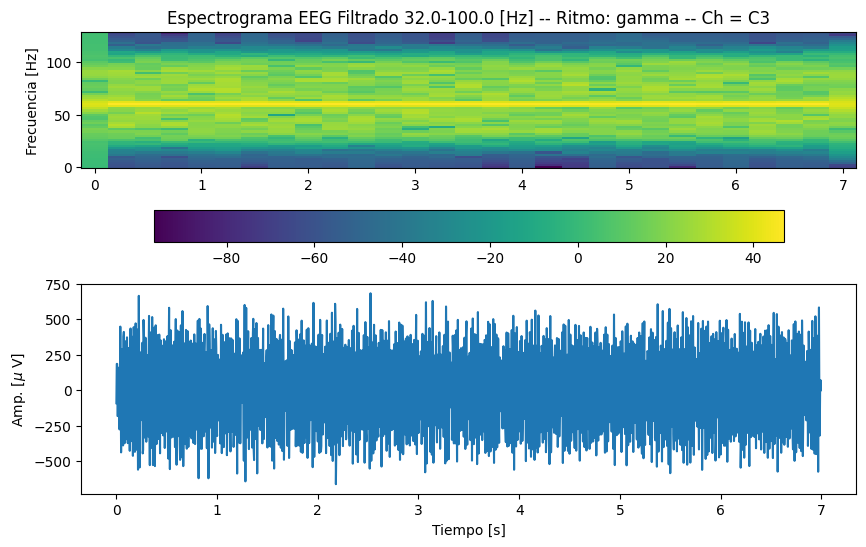

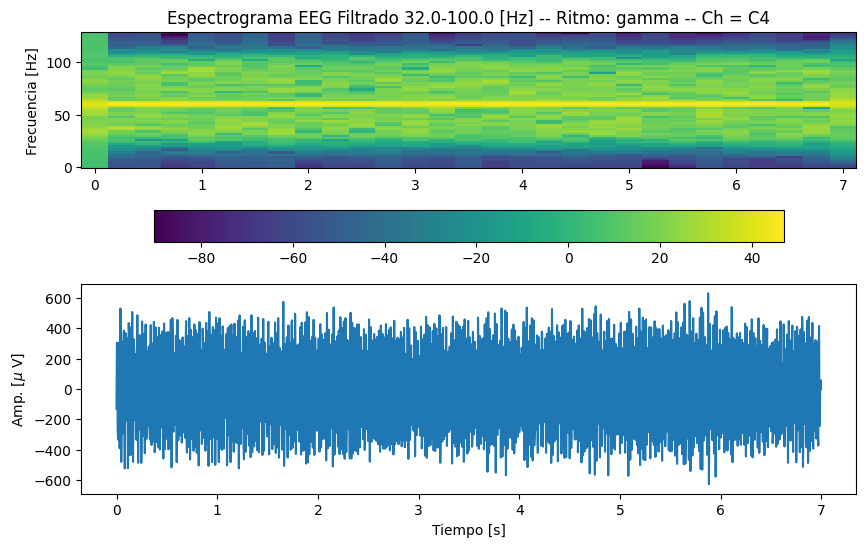

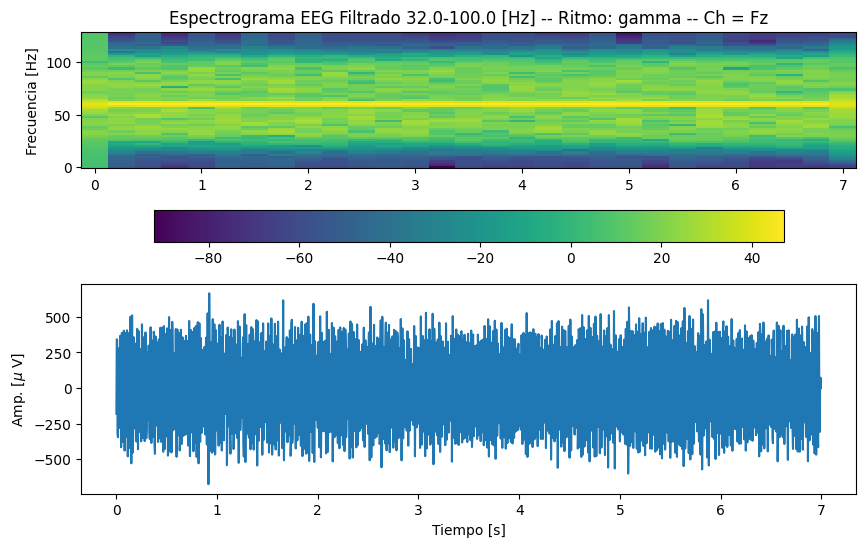

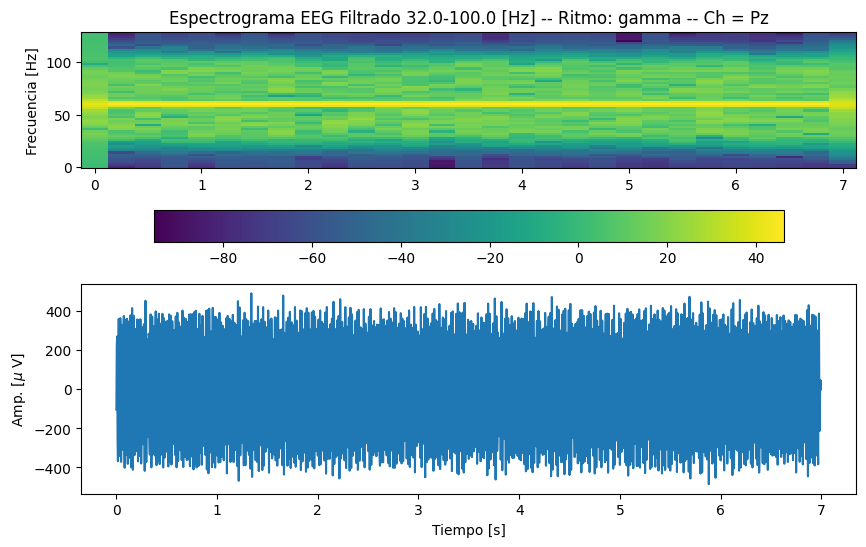

In [17]:
canales_interes = ['C3', 'C4', 'Fz', 'Pz']
indices_canales = [channels.index(ch) for ch in canales_interes]

from scipy.signal import stft
import matplotlib.pyplot as plt

# Parámetros para la STFT
nperseg = 0.5 * new_fs  # Longitud de la ventana en muestras (0.5 segundos)

# Bucle sobre los ritmos cerebrales
for b, ritmo_nombre in enumerate(ritmo):
    print(f"Procesando ritmo: {ritmo_nombre} ({f_bank[b, 0]}-{f_bank[b, 1]} Hz)")
    
    # Calcular STFT para la banda actual
    vfs, t, Xstftb = stft(Xrc[:, :, :, b], fs=new_fs, nperseg=nperseg, axis=2)
    Xstftb = 20 * np.log10(abs(Xstftb))  # Convertir a dB

    # Graficar para cada canal de interés
    for ch_nombre, ch_idx in zip(canales_interes, indices_canales):
        fig, ax = plt.subplots(2, 1, figsize=(10, 6))
        
        # Parte superior: Espectrograma
        im = ax[0].pcolormesh(t, vfs, Xstftb[trail, ch_idx])
        fig.colorbar(im, ax=ax[0], orientation="horizontal", pad=0.2)
        ax[0].set_title(f'Espectrograma EEG Filtrado {f_bank[b, 0]}-{f_bank[b, 1]} [Hz] -- Ritmo: {ritmo_nombre} -- Ch = {ch_nombre}')
        ax[0].set_ylabel('Frecuencia [Hz]')
        
        # Parte inferior: Señal temporal
        ax[1].plot(tv, Xrc[trail, ch_idx, :, b])
        ax[1].set_ylabel("Amp. [$\mu$ V]")
        ax[1].set_xlabel('Tiempo [s]')
        
        plt.show()

Las gráficas que obtuvimos al analizar las señales EEG, prestando especial atención a las diferentes bandas de frecuencia: delta, theta, alpha, beta y gamma. Cada una de estas bandas está relacionada con estados cerebrales específicos, como la relajación, la concentración o el sueño, y nos da pistas sobre lo que estaba ocurriendo en el cerebro durante el experimento.

Gracias a los espectrogramas, podemos observar cómo la actividad eléctrica varía a lo largo del tiempo y cómo se distribuye en distintas áreas del cerebro. Esto nos permite entender mejor qué regiones estaban más activas durante ciertos momentos y cómo estas activaciones se relacionan con las tareas o estados mentales del sujeto. En otras palabras, estas gráficas nos ayudan a "ver" lo que estaba pasando en el cerebro mientras se realizaba el ensayo.

Ritmo Delta (0.5-4 Hz)
En las regiones C3 y C4, la actividad delta suele ser bastante baja cuando estamos despiertos. Si aparece actividad en este rango (0.5 a 4 Hz), podría ser una señal de un estado de sueño profundo o de una relajación extrema. En el espectrograma, esta actividad se refleja claramente en estas frecuencias bajas.

Por otro lado, en las zonas Fz y Pz, que corresponden a los lóbulos frontal y parietal, la presencia de ondas delta está más vinculada a estados de sueño o fatiga. En el espectrograma, podemos observar esta actividad en el mismo rango de frecuencias.

Ritmo Theta (4-8 Hz)
En la corteza motora (C3 y C4), la actividad theta suele aparecer en momentos de somnolencia o relajación, y podemos identificarla en el espectrograma entre 4 y 8 Hz.

En las regiones Fz y Pz, las ondas theta tienen una interpretación un poco más variada. En el lóbulo frontal (Fz), se asocian con la atención y la meditación, mientras que en el lóbulo parietal (Pz) pueden estar relacionadas con el procesamiento emocional.

Ritmo Alpha (8-13 Hz)
La actividad alpha en las regiones C3 y C4 es bastante característica de estados de relajación, especialmente cuando tenemos los ojos cerrados. Este patrón es fácilmente visible en el espectrograma en el rango de 8 a 13 Hz.

En las áreas Fz y Pz, las ondas alpha también indican relajación, pero con matices distintos. En el lóbulo frontal (Fz), suelen reflejar una desconexión del entorno, mientras que en el lóbulo parietal (Pz) están más asociadas a la integración sensorial.

Ritmo Beta (13-32 Hz)
En la corteza motora (C3 y C4), las ondas beta se relacionan con estados de alerta y con la preparación para el movimiento. En el espectrograma, se presentan en el rango de 13 a 32 Hz.

Por su parte, en Fz y Pz, la actividad beta tiene diferentes implicaciones. En el lóbulo frontal (Fz), está asociada a la concentración y la resolución de problemas, mientras que en el lóbulo parietal (Pz) se vincula al procesamiento de información sensorial.

Ritmo Gamma (32-100 Hz)
Las ondas gamma, que se encuentran en el rango de 32 a 100 Hz, están relacionadas con procesos cognitivos más complejos. En la corteza motora (C3 y C4), esta actividad suele vincularse con la planificación del movimiento.

En las zonas Fz y Pz, las ondas gamma cumplen funciones diferentes. En el lóbulo frontal (Fz), están asociadas con la atención y la memoria de trabajo, mientras que en el lóbulo parietal (Pz) se relacionan con la integración de información multisensorial.

## Visualización de señales EEG sobre montaje 10-20

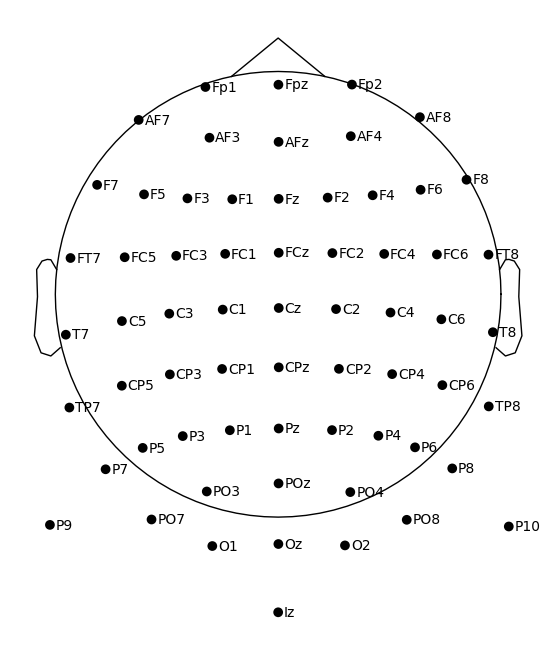

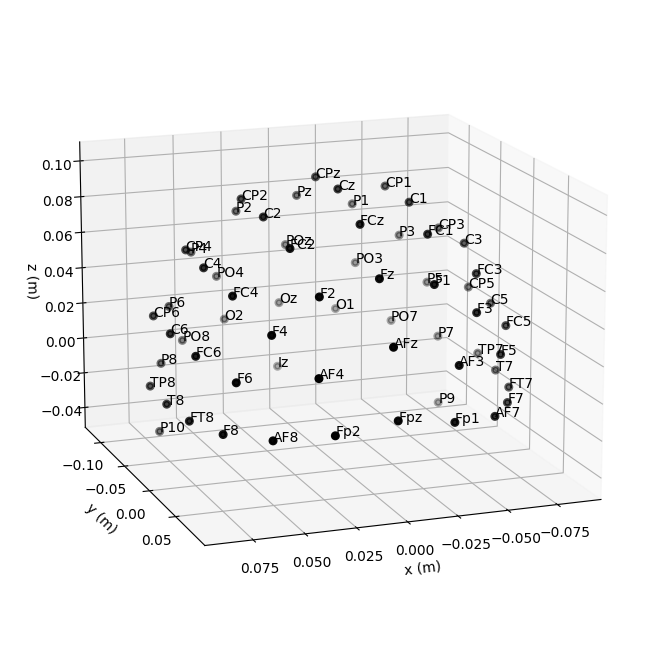

In [18]:
import mne

# Cargar el montaje estándar
easycap_montage = mne.channels.make_standard_montage("standard_1020")


# Crear un montaje personalizado con los electrodos seleccionados
custom_pos = {ch: easycap_montage.get_positions()["ch_pos"][ch] for ch in channels}
custom_montage = mne.channels.make_dig_montage(ch_pos=custom_pos, coord_frame="head")

# Mostrar el montaje personalizado
custom_montage.plot(show_names=True)
fig = custom_montage.plot(kind="3d", show_names=True, show=False)
fig.gca().view_init(azim=70, elev=15)  # Ajustar la vista 3D

In [19]:
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.visualizations.git

  Cloning https://github.com/UN-GCPDS/python-gcpds.visualizations.git to /tmp/pip-req-build-2cgiq5py
  Running command git clone --filter=blob:none --quiet https://github.com/UN-GCPDS/python-gcpds.visualizations.git /tmp/pip-req-build-2cgiq5py
  Resolved https://github.com/UN-GCPDS/python-gcpds.visualizations.git to commit 162dbeac141a7472d3b0bd7f005932241b4663a5
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 45.3 MB/s eta 0:00:00
  Created wheel for gcpds-visualizations: filename=gcpds_visualizations-0.6-py3-none-any.whl size=12439 sha256=2367f97c44bd3ed0201e9b03c17aa259ab11362267df347f870f3e67098be18d
  Stored in directory: /tmp/pip-ephem-wheel-cache-sy10n8e2/wheels/fa/f8/e8/78c4b4940a8349e29d9199eee5e3c5f526123608864b3834af
Successfully built gcpds-visualizations


# Topomaps

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


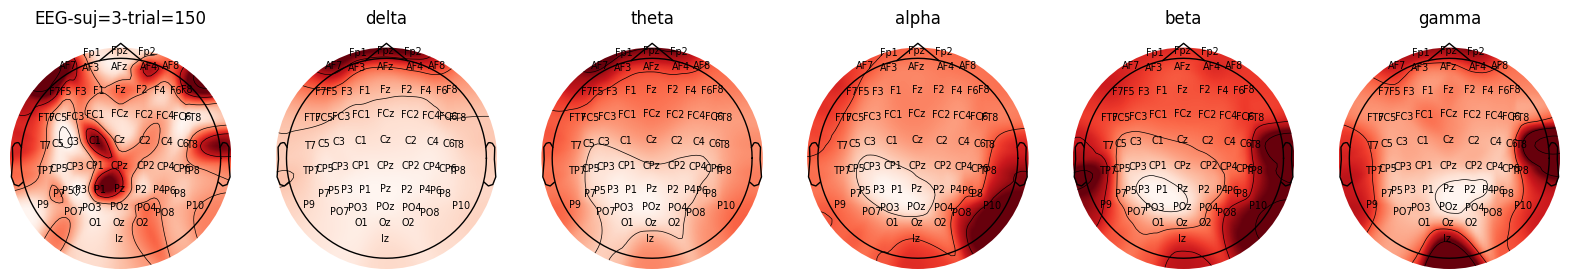

In [20]:
from gcpds.visualizations.topoplots import topoplot


trial = 150
vec_topo_o = abs(X[trial,:]).mean(axis=-1)
vec_topo_b = abs(Xrc[trial,:,:,:]).mean(axis=1)


fig,ax = plt.subplots(1,6,figsize=(20,10))
topoplot(vec_topo_o, channels, contours=3, cmap='Reds', names=channels, sensors=False,ax=ax[0],show=False,vlim=(min(vec_topo_o), max(vec_topo_o)))

for b in range(f_bank.shape[0]):
    vec_ = vec_topo_b[:,b]
    topoplot(vec_, channels, contours=3, cmap='Reds', names=channels, sensors=False,ax=ax[b+1],show=False,vlim=(min(vec_), max(vec_)))
    ax[b+1].set_title(ritmo[b])    

ax[0].set_title(f'EEG-suj={sbj}-trial={trial}')    

plt.show()

## Ejercicio 7

Discuta

En los mapas topográficos generados a partir de las señales EEG, la actividad cerebral se representa usando una escala de colores que nos ayuda a visualizar la intensidad de la actividad eléctrica en diferentes zonas del cerebro.

Los colores cálidos, como el rojo y el naranja, indican áreas con mayor actividad eléctrica. Estas zonas reflejan regiones del cerebro que están trabajando de manera más intensa durante el ensayo analizado. Por otro lado, los colores fríos, muestran áreas con menor actividad eléctrica, lo que sugiere que esas regiones están en un estado de menor activación o reposo relativo.

Estos mapas ofrecen una visión general de cómo se distribuye la actividad eléctrica en la superficie del cuero cabelludo, permitiéndonos identificar patrones espaciales relacionados con tareas específicas o estados cognitivos.

Cuando observamos una mayor actividad en ciertas regiones específicas del mapa, esto puede estar relacionado con funciones particulares del cerebro. Por ejemplo:

Corteza motora: Una mayor actividad en las regiones C3 o C4 del mapa podría indicar que el sujeto está realizando una tarea motora o imaginando un movimiento. En experimentos de imaginación motora, es común ver una activación en la corteza motora contralateral; es decir, si la persona imagina mover la mano derecha, se activa la corteza motora izquierda, y viceversa.

Corteza frontal: Un aumento en la actividad de esta región suele estar asociado con procesos como la atención, la planificación o la toma de decisiones.

Corteza occipital: Si la actividad se concentra en esta zona, probablemente esté relacionada con el procesamiento visual, especialmente si la tarea implica estímulos visuales.

Este análisis es muy útil para entender cómo el cerebro distribuye sus recursos durante diferentes actividades. Por ejemplo, en experimentos de imaginación motora, la activación de la corteza motora es una señal clara de que el sujeto está siguiendo las instrucciones y simulando el movimiento sin ejecutarlo físicamente.

Además, la distribución espacial de la actividad también puede reflejar diferentes estados cognitivos o emocionales. Por ejemplo, un aumento de la actividad en la banda alpha en la región occipital suele asociarse con estados de relajación o cierre de ojos, mientras que una mayor actividad en la banda beta en la corteza frontal puede indicar un estado de concentración o alerta.

## Common Spatial Patterns

In [21]:
import mne
from mne.decoding import CSP

# Instancia del objeto CSP
n_components = 2
csp = CSP(n_components=n_components, log= True, transform_into='average_power')
# Ajuste y transformación de los datos
csp_data = csp.fit_transform(X.astype(np.float64), y)

CSP Transformado Shape: (200, 2)


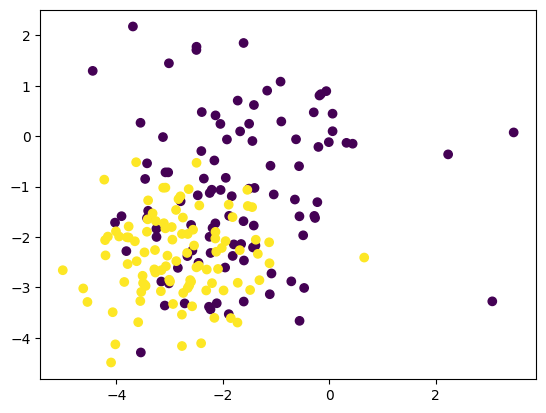

In [22]:
print("CSP Transformado Shape:", csp_data.shape)
plt.scatter(csp_data[:,0],csp_data[:,1],c=y)
plt.show()

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


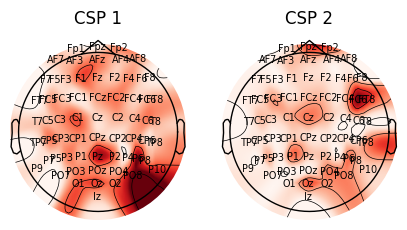

In [23]:
#EEG original
fig,ax = plt.subplots(1,n_components,figsize=(5,5))
for cc in range(n_components):
    vec_ = np.abs(csp.filters_[cc])
    topoplot(vec_, channels, contours=3, cmap='Reds', names=channels, sensors=False,ax=ax[cc],show=False,vlim=(min(vec_), max(vec_)))
    ax[cc].set_title(f'CSP {cc+1}') 


In [24]:
#lectura de datos
sbj = 7
X, y = load_GIGA(sbj=sbj, **load_args)

f_bank = np.array([[0.5,4.],[4., 8.],[8.,13.],[13.,32.],[32.,100.]])
vwt = np.array([[0.25, 1.75],[1.5,3],[2.75,4.25],[4,5.5],[5.25,6.75]]) #2.5 - 5 MI 0 - 7 trial completo
tf_repr = TimeFrequencyRpr(sfreq = new_fs, f_bank = f_bank,vwt=vwt)
X_ = np.squeeze(tf_repr.transform(X))
X_.shape

Resampling from 512.000000 to 256.000000 Hz.


(240, 64, 384, 5, 5)

In [25]:
# csp por ventanas y ritmos
# Definir las dimensiones del arreglo
ritmos_ = f_bank.shape[0] 
ventanas_ = vwt.shape[0]
n_comp = 2
# Inicializar el arreglo vacío con listas anidadas
csp_M = [[None for _ in range(ventanas_)] for _ in range(ritmos_)]
csp_filters_ = np.zeros((ritmos_,ventanas_,X_.shape[1],X_.shape[1])) #ritmos ventanas Ch
Xcsp_ = np.zeros((X_.shape[0],n_comp,ritmos_,ventanas_))

for i in range(ritmos_):
    for j in range(ventanas_):
        print(f'CSP ritmo {f_bank[i]} -- ventana {vwt[j]}...')
        csp_M[i][j] =  CSP(n_components=n_comp, log= True, transform_into='average_power')
        Xcsp_[:,:,i,j] = csp.fit_transform(X_[:,:,:,j,i].astype(np.float64), y)
        csp_filters_[i,j,:] = np.abs(csp.filters_) 

CSP ritmo [0.5 4. ] -- ventana [0.25 1.75]...
CSP ritmo [0.5 4. ] -- ventana [1.5 3. ]...
CSP ritmo [0.5 4. ] -- ventana [2.75 4.25]...
CSP ritmo [0.5 4. ] -- ventana [4.  5.5]...
CSP ritmo [0.5 4. ] -- ventana [5.25 6.75]...
CSP ritmo [4. 8.] -- ventana [0.25 1.75]...
CSP ritmo [4. 8.] -- ventana [1.5 3. ]...
CSP ritmo [4. 8.] -- ventana [2.75 4.25]...
CSP ritmo [4. 8.] -- ventana [4.  5.5]...
CSP ritmo [4. 8.] -- ventana [5.25 6.75]...
CSP ritmo [ 8. 13.] -- ventana [0.25 1.75]...
CSP ritmo [ 8. 13.] -- ventana [1.5 3. ]...
CSP ritmo [ 8. 13.] -- ventana [2.75 4.25]...
CSP ritmo [ 8. 13.] -- ventana [4.  5.5]...
CSP ritmo [ 8. 13.] -- ventana [5.25 6.75]...
CSP ritmo [13. 32.] -- ventana [0.25 1.75]...
CSP ritmo [13. 32.] -- ventana [1.5 3. ]...
CSP ritmo [13. 32.] -- ventana [2.75 4.25]...
CSP ritmo [13. 32.] -- ventana [4.  5.5]...
CSP ritmo [13. 32.] -- ventana [5.25 6.75]...
CSP ritmo [ 32. 100.] -- ventana [0.25 1.75]...
CSP ritmo [ 32. 100.] -- ventana [1.5 3. ]...
CSP ritmo [ 

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


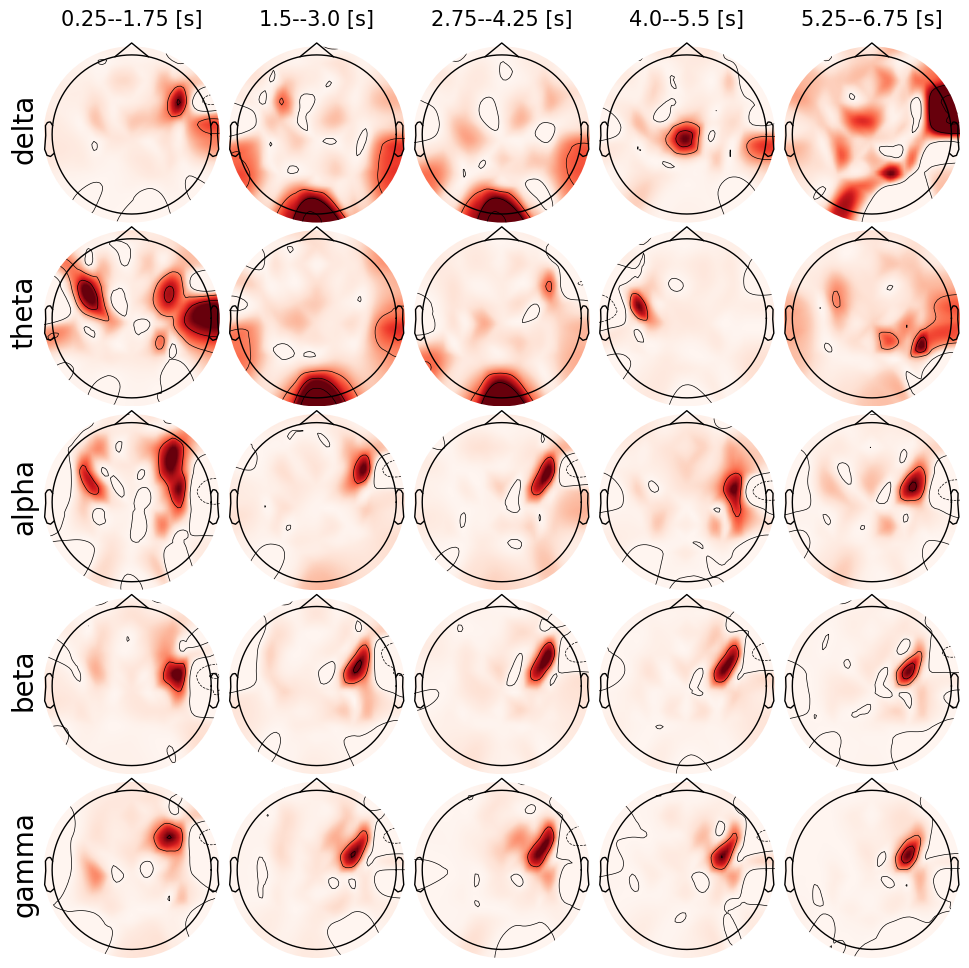

In [26]:
# graficar topomaps
fig, ax = plt.subplots(ritmos_,ventanas_,figsize=(12,12))

for i in range(ritmos_):
    for j in range(ventanas_):
        vec_ = csp_filters_[i,j,0]
        vec_ = vec_/max(vec_)
        topoplot(vec_, channels, contours=3, cmap='Reds', names=None, sensors=False,ax=ax[i,j],show=False,vlim=(min(vec_), max(vec_)))
    ax[i,0].set_ylabel(ritmo[i],fontsize=20)   
for j in range(ventanas_):
     ax[0,j].set_title(f'{vwt[j,0]}--{vwt[j,1]} [s]',fontsize=15)
    
plt.subplots_adjust(hspace=-0.025,wspace=-0.025)    
plt.show()      

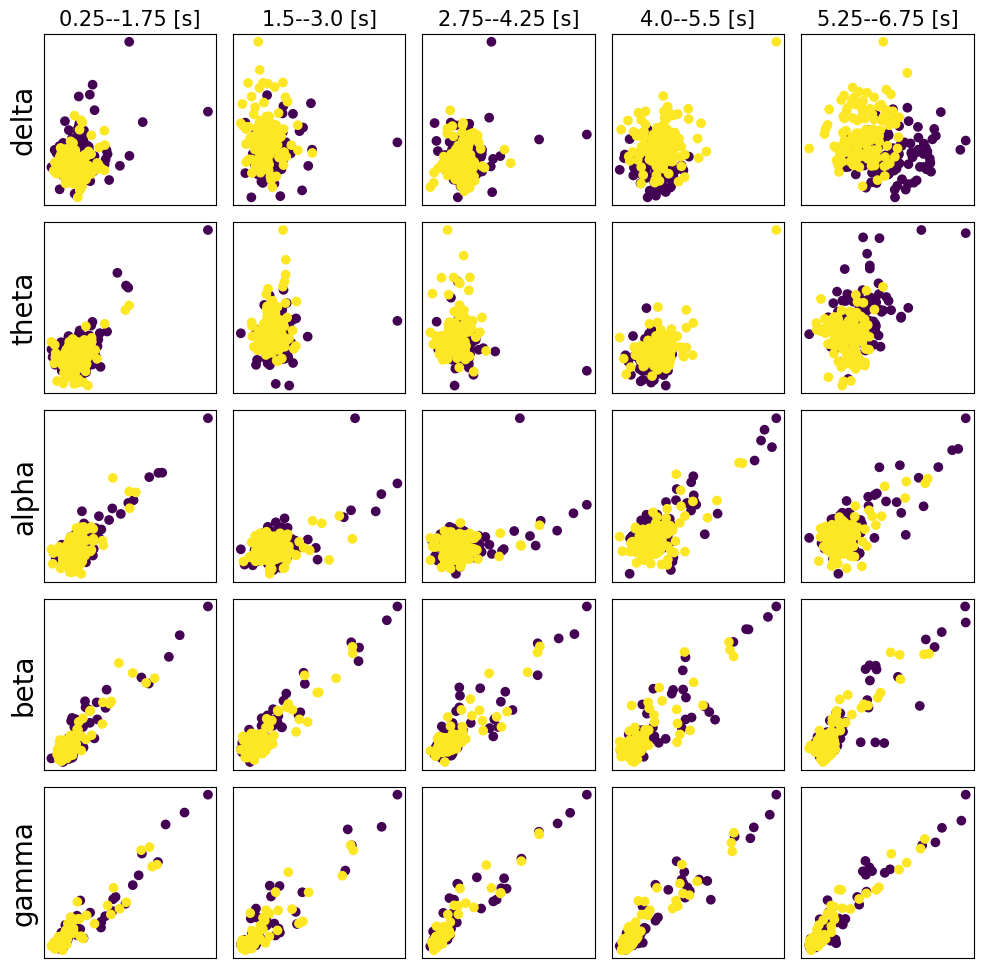

In [27]:
#scatters
fig, ax = plt.subplots(ritmos_,ventanas_,figsize=(12,12))

for i in range(ritmos_):
    for j in range(ventanas_):
        ax[i,j].scatter(Xcsp_[:,0,i,j],Xcsp_[:,1,i,j],c=y)
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
    ax[i,0].set_ylabel(ritmo[i],fontsize=20)   
for j in range(ventanas_):
     ax[0,j].set_title(f'{vwt[j,0]}--{vwt[j,1]} [s]',fontsize=15)
    
plt.subplots_adjust(hspace=0.1,wspace=0.1)    
plt.show()  

In [28]:
# calculamos las matrices de coectividades (correlación)

N = X.shape[0]
connectivities_v = np.array([np.corrcoef(X[i]) for i in range(N)])

print(connectivities_v.shape)  

(240, 64, 64)


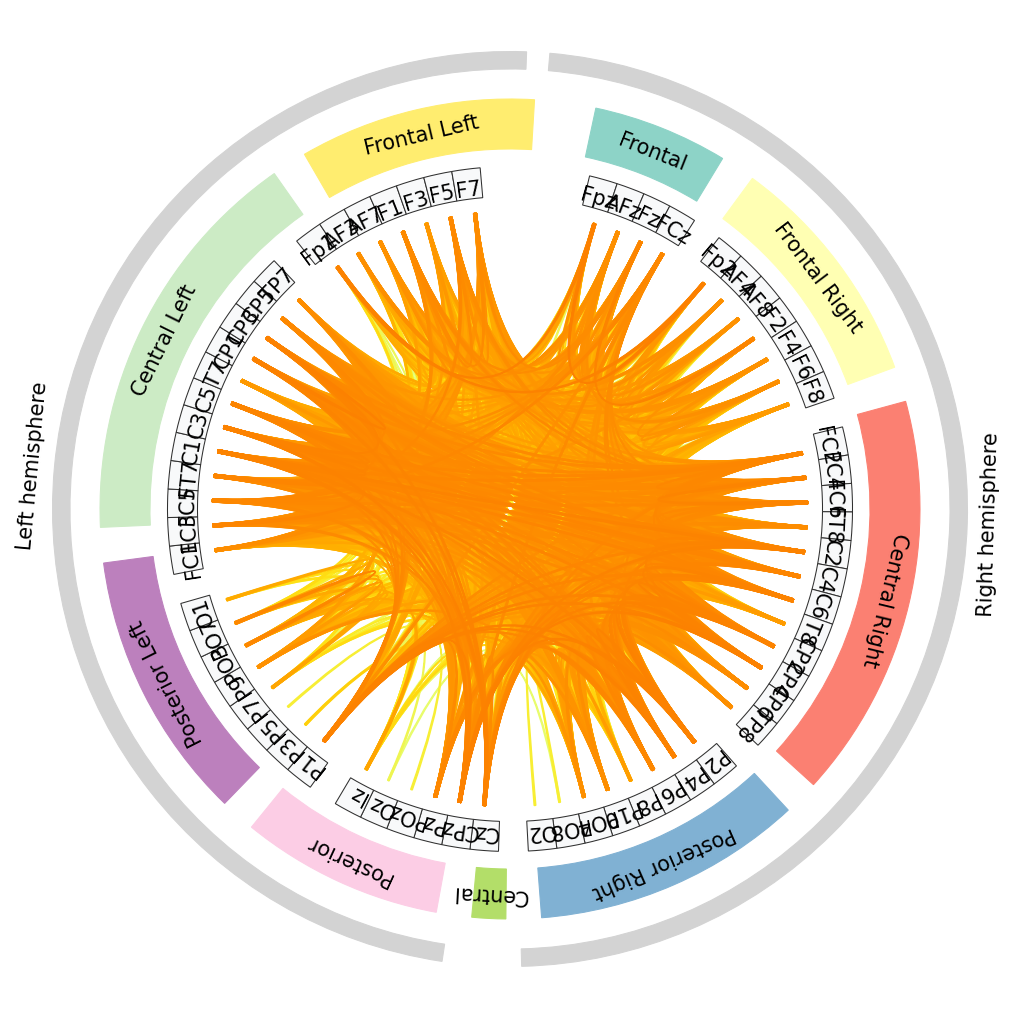

In [29]:
from gcpds.visualizations.connectivities import CircosConnectivity

N = len(channels)  # channels

areas = {
    'Frontal': ['Fpz', 'AFz', 'Fz', 'FCz'],
    'Frontal Right': ['Fp2','AF4','AF8','F2','F4','F6','F8',],
    'Central Right': ['FC2','FC4','FC6','FT8','C2','C4','C6','T8','CP2','CP4','CP6','TP8',],
    'Posterior Right': ['P2','P4','P6','P8','P10','PO4','PO8','O2',],
    'Central': ['Cz'],
    'Posterior': ['CPz','Pz', 'Cz','POz','Oz','Iz',],
    'Posterior Left': ['P1','P3','P5','P7','P9','PO3','PO7','O1',],
    'Central Left': ['FC1','FC3','FC5','FT7','C1','C3','C5','T7','CP1','CP3','CP5','TP7',],
    'Frontal Left': ['Fp1','AF3','AF7','F1','F3','F5','F7',],
}


conn = CircosConnectivity(
    connectivities_v[0,:,:], channels, areas=areas, threshold=0.7,

    # cmaps and themes
    areas_cmap='Set3',
    arcs_cmap='Wistia',
    hemisphere_color='lightgray',
    channel_color='#f8f9fa',
    min_alpha=0,


    # Texts
    width={'hemispheres':35, 'areas':100, 'channels':60},
    text={'hemispheres':40, 'areas':20,  'channels':40},
    separation={'hemispheres':10, 'areas':-30, 'channels':5},
    labelposition={'hemispheres':60, 'areas':0, 'channels':-10},
    size=10,
    labelsize=15,


    # Shapes
    show_emisphere=True,
    arcs_separation=30,
    connection_width=0.1,
    small_separation=5,
    big_separation=10,
    offset=0,
)

conn.figure;


## Topoplots

In [30]:
# promediemos por canales

connecitivities_mean = np.mean(connectivities_v[0],axis=1)

## Graficamos las bandas de frecuencia usando fourier para el calculo